In [1]:
import os

processed_path = "../data/processed"
print(os.listdir(processed_path))


['city_day_processed.csv', 'city_day_sample.csv', 'city_hour_processed.csv', 'city_hour_sample.csv', 'stations_processed.csv', 'stations_sample.csv', 'station_day_processed.csv', 'station_day_sample.csv', 'station_hour_processed.csv', 'station_hour_sample.csv']


In [2]:
import pandas as pd

city_day     = pd.read_csv("../data/processed/city_day_processed.csv")
city_hour    = pd.read_csv("../data/processed/city_hour_processed.csv")
station_day  = pd.read_csv("../data/processed/station_day_processed.csv")
station_hour = pd.read_csv("../data/processed/station_hour_processed.csv")
stations     = pd.read_csv("../data/processed/stations_processed.csv")


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\2662841152.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  city_hour    = pd.read_csv("../data/processed/city_hour_processed.csv")
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\2662841152.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  station_hour = pd.read_csv("../data/processed/station_hour_processed.csv")


In [3]:
# Cell 1 - imports & settings
import os, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import xgboost as xgb
# optional
import lightgbm as lgb

%matplotlib inline
sns.set(style="whitegrid")


All imports successful!


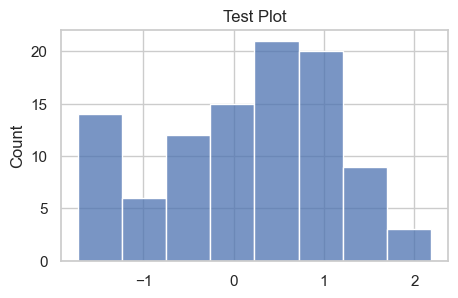

XGBoost version: 2.0.3
LightGBM version: 4.3.0


In [4]:
print("All imports successful!")

# Optional test plot
plt.figure(figsize=(5,3))
sns.histplot(np.random.randn(100))
plt.title("Test Plot")
plt.show()

# Check XGBoost & LightGBM
print("XGBoost version:", xgb.__version__)
print("LightGBM version:", lgb.__version__)


In [5]:
# === Cell 1: Imports ===
import os
import pandas as pd

# === Cell 2: Safe load function ===
proc_dir = "../data/processed"

# List all files in the processed directory
files = {f: os.path.join(proc_dir, f) for f in os.listdir(proc_dir)}

def safe_load(name_startswith):
    """
    Load a CSV or Parquet file safely from the processed folder.
    """
    for fname, path in files.items():
        if fname.lower().startswith(name_startswith.lower()):
            print("Loading file:", fname)
            try:
                if fname.endswith(".parquet"):
                    return pd.read_parquet(path)
                else:
                    # set low_memory=False to avoid DtypeWarning
                    return pd.read_csv(path, parse_dates=True, low_memory=False)
            except Exception as e:
                print("Error loading file:", fname, e)
    print(f"No file found starting with '{name_startswith}'")
    return None

# === Cell 3: Load city_hour and station_hour ===
city_hour = safe_load("city_hour_processed")
if city_hour is None:
    city_hour = safe_load("city_hour")
if city_hour is None:
    city_hour = pd.read_csv("../data/raw/city_hour.csv", parse_dates=True, low_memory=False)

station_hour = safe_load("station_hour_processed")
if station_hour is None:
    station_hour = safe_load("station_hour")
if station_hour is None:
    station_hour = pd.read_csv("../data/raw/station_hour.csv", parse_dates=True, low_memory=False)

# === Cell 4: Output basic info ===
print("city_hour rows:", len(city_hour), "columns:", len(city_hour.columns))
print("station_hour rows:", len(station_hour), "columns:", len(station_hour.columns))
print("city_hour columns sample:", city_hour.columns.tolist()[:20])
print("station_hour columns sample:", station_hour.columns.tolist()[:20])


Loading file: city_hour_processed.csv
Loading file: station_hour_processed.csv
city_hour rows: 707875 columns: 37
station_hour rows: 2589083 columns: 37
city_hour columns sample: ['City', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket', 'hour', 'dayofweek', 'month', 'hour_sin']
station_hour columns sample: ['StationId', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket', 'hour', 'dayofweek', 'month', 'hour_sin']


In [6]:
# Cell 3 - canonicalize names and detect key columns
def clean_cols(df):
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ", "_").replace(".", "").replace("-", "_").replace("/", "_") for c in df.columns]
    return df

city_hour = clean_cols(city_hour)
station_hour = clean_cols(station_hour)

print("city_hour sample cols:", city_hour.columns[:30])
print("station_hour sample cols:", station_hour.columns[:30])

# find candidate target names
for candidates in [["pm25","pm2_5","pm2.5","pm25_ugm3"], ["aqi","aqi_calc"], ["aqi_bucket","aqi_category"]]:
    for c in candidates:
        if c in city_hour.columns:
            print("Found candidate target:", c)
            break


city_hour sample cols: Index(['city', 'datetime', 'pm25', 'pm10', 'no', 'no2', 'nox', 'nh3', 'co',
       'so2', 'o3', 'benzene', 'toluene', 'xylene', 'aqi', 'aqi_bucket',
       'hour', 'dayofweek', 'month', 'hour_sin', 'hour_cos', 'pm25_lag1',
       'pm25_lag3', 'pm25_lag6', 'pm25_lag12', 'pm25_lag24', 'pm10_lag1',
       'pm10_lag3', 'pm10_lag6', 'pm10_lag12'],
      dtype='object')
station_hour sample cols: Index(['stationid', 'datetime', 'pm25', 'pm10', 'no', 'no2', 'nox', 'nh3',
       'co', 'so2', 'o3', 'benzene', 'toluene', 'xylene', 'aqi', 'aqi_bucket',
       'hour', 'dayofweek', 'month', 'hour_sin', 'hour_cos', 'pm25_lag1',
       'pm25_lag3', 'pm25_lag6', 'pm25_lag12', 'pm25_lag24', 'pm10_lag1',
       'pm10_lag3', 'pm10_lag6', 'pm10_lag12'],
      dtype='object')
Found candidate target: pm25
Found candidate target: aqi
Found candidate target: aqi_bucket


In [7]:
# Cell 4 - quick summary
def quick_summary(df, name):
    print(f"--- {name} ---")
    print("rows:", len(df))
    if "timestamp" in df.columns:
        print("range:", df["timestamp"].min(), "->", df["timestamp"].max())
    if "city" in df.columns:
        print("unique cities:", df["city"].nunique())
    if "stationid" in df.columns:
        print("unique stations:", df["stationid"].nunique())
    print("missing % (top 8):")
    print((df.isna().mean()*100).sort_values(ascending=False).head(8))
    print()

quick_summary(city_hour, "city_hour")
quick_summary(station_hour, "station_hour")


--- city_hour ---
rows: 707875
unique cities: 26
missing % (top 8):
xylene        64.393996
pm10_lag24    41.995691
pm10_lag12    41.957973
pm10_lag6     41.938760
pm10_lag3     41.929013
pm10_lag1     41.922515
pm10          41.919407
pm10_roll3    40.577221
dtype: float64

--- station_hour ---
rows: 2589083
unique stations: 110
missing % (top 8):
xylene        80.148222
nh3           47.762779
pm10_lag24    43.303363
pm10_lag12    43.267481
pm10_lag6     43.248826
pm10_lag3     43.239209
pm10_lag1     43.232836
pm10          43.229669
dtype: float64



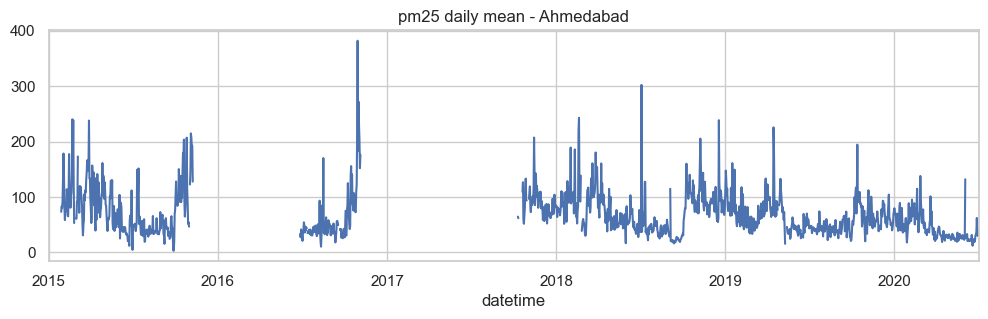

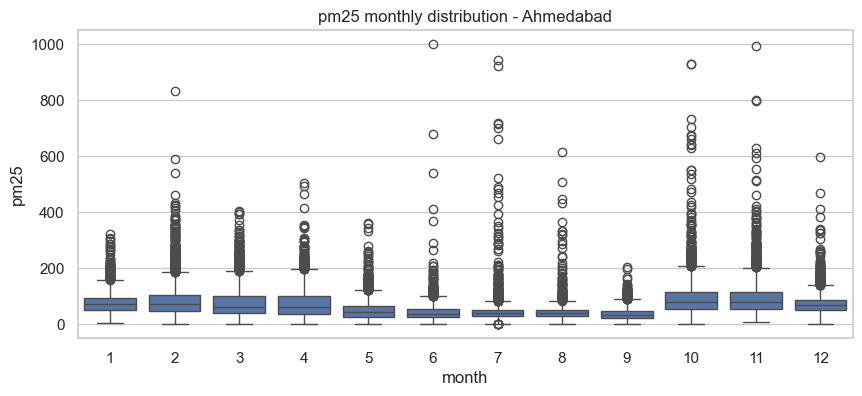

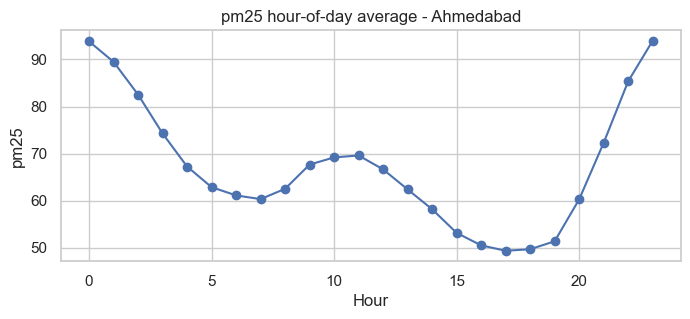

Summary statistics for Ahmedabad:
count    31129.000000
mean        67.273271
std         53.913369
min          0.340000
25%         35.080000
50%         53.500000
75%         83.030000
max        999.990000
Name: pm25, dtype: float64


In [8]:
# Detect columns
target_candidates = ['PM2.5', 'pm25', 'PM25']
city_candidates = ['City', 'city']
datetime_candidates = ['Datetime', 'datetime', 'Timestamp', 'timestamp']

target = next((col for col in target_candidates if col in city_hour.columns), None)
city_col = next((col for col in city_candidates if col in city_hour.columns), None)
datetime_col = next((col for col in datetime_candidates if col in city_hour.columns), None)

if target and city_col and datetime_col:
    # Convert datetime column
    city_hour[datetime_col] = pd.to_datetime(city_hour[datetime_col], errors='coerce')
    city_hour = city_hour.dropna(subset=[datetime_col])

    # Pick top city
    top_city = city_hour[city_col].value_counts().index[0]
    ch = city_hour[city_hour[city_col]==top_city].set_index(datetime_col).sort_index()

    # Daily mean
    daily = ch[target].resample('D').mean()
    plt.figure(figsize=(12,3))
    daily.plot()
    plt.title(f"{target} daily mean - {top_city}")
    plt.show()

    # Monthly boxplot
    ch['month'] = ch.index.month
    plt.figure(figsize=(10,4))
    sns.boxplot(x='month', y=target, data=ch.reset_index())
    plt.title(f"{target} monthly distribution - {top_city}")
    plt.show()

    # Hour of day mean
    hod = ch.groupby(ch.index.hour)[target].mean()
    plt.figure(figsize=(8,3))
    plt.plot(hod.index, hod.values, '-o')
    plt.title(f"{target} hour-of-day average - {top_city}")
    plt.xlabel("Hour")
    plt.ylabel(target)
    plt.show()

    # Summary stats
    print(f"Summary statistics for {top_city}:")
    print(ch[target].describe())

else:
    print("City, target, or datetime column not found. Adjust column names.")


In [9]:
# Cell 6 - IQR clipping per city or global
def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    low = s.quantile(lower_q)
    high = s.quantile(upper_q)
    return s.clip(lower=low, upper=high)

# apply winsorization to pm25 in city_hour per city
if target in city_hour.columns:
    city_hour[f"{target}_wins"] = city_hour.groupby("city")[target].transform(lambda s: winsorize_series(s))
    print("Winsorized target created:", f"{target}_wins")


Winsorized target created: pm25_wins


In [10]:
# Show first 5 rows
city_hour[[target, f"{target}_wins"]].head()


,pm25,pm25_wins
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [11]:
city_hour[[target, f"{target}_wins"]].tail(10)


,pm25,pm25_wins
707865,15.75,15.75
707866,14.00,14.00
707867,9.75,9.75
707868,6.50,6.50
707869,8.25,8.25
707870,9.50,9.50
707871,17.25,17.25
707872,36.00,36.00
707873,15.75,15.75
707874,15.00,15.00


In [12]:
# Detect city and datetime columns automatically
city_col = next((col for col in ['City','city','CITY'] if col in city_hour.columns), None)
datetime_col = next((col for col in ['Datetime','datetime','Timestamp','timestamp'] if col in city_hour.columns), None)
target_wins = next((col for col in ['pm25_wins','PM2.5_wins'] if col in city_hour.columns), None)

if not city_col or not datetime_col or not target_wins:
    raise ValueError(f"Columns not found. city: {city_col}, datetime: {datetime_col}, target_wins: {target_wins}")

# Ensure datetime column is proper datetime type
city_hour[datetime_col] = pd.to_datetime(city_hour[datetime_col], errors='coerce')
city_hour = city_hour.dropna(subset=[datetime_col])

# Sort by city and datetime
df = city_hour.sort_values([city_col, datetime_col]).copy()

# Basic calendar features
df['hour'] = df[datetime_col].dt.hour
df['dayofweek'] = df[datetime_col].dt.dayofweek
df['month'] = df[datetime_col].dt.month

# Lags for winsorized PM2.5
for lag in [1,3,6,12,24,48,72]:
    df[f"pm25_lag_{lag}"] = df.groupby(city_col)[target_wins].shift(lag)

# Rolling means
for w in [3,6,12,24]:
    df[f"pm25_roll_{w}"] = df.groupby(city_col)[target_wins].rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)

# Drop rows with NaN in first lag
df = df.dropna(subset=[f"pm25_lag_1"]).copy()

print("After feature engineering, rows:", len(df))
df.head()


After feature engineering, rows: 562764


,city,datetime,pm25,pm10,no,no2,nox,nh3,co,so2,...,pm25_lag_3,pm25_lag_6,pm25_lag_12,pm25_lag_24,pm25_lag_48,pm25_lag_72,pm25_roll_3,pm25_roll_6,pm25_roll_12,pm25_roll_24
666,Ahmedabad,2015-01-28 19:00:00,40.63,NaN,0.77,25.43,29.27,NaN,0.77,73.37,...,NaN,NaN,NaN,NaN,NaN,NaN,38.615000,38.615000,38.615000,38.615000
667,Ahmedabad,2015-01-28 20:00:00,57.07,NaN,5.35,44.17,54.60,NaN,5.35,79.28,...,NaN,NaN,NaN,NaN,NaN,NaN,44.766667,44.766667,44.766667,44.766667
668,Ahmedabad,2015-01-28 21:00:00,81.30,NaN,23.23,47.66,75.67,NaN,23.23,50.19,...,36.60,NaN,NaN,NaN,NaN,NaN,59.666667,53.900000,53.900000,53.900000
669,Ahmedabad,2015-01-28 22:00:00,105.53,NaN,43.73,45.93,94.58,NaN,43.73,31.99,...,40.63,NaN,NaN,NaN,NaN,NaN,81.300000,64.226000,64.226000,64.226000
670,Ahmedabad,2015-01-28 23:00:00,118.33,NaN,39.17,43.69,87.27,NaN,39.17,44.06,...,57.07,NaN,NaN,NaN,NaN,NaN,101.720000,73.243333,73.243333,73.243333


In [13]:
# Run this cell only if the packages are not installed already.
# In VS Code terminal you can also run: pip install scikit-learn xgboost prophet tensorflow matplotlib seaborn joblib

import sys
print("If the imports later fail, run in terminal:")
print("pip install scikit-learn xgboost prophet tensorflow matplotlib seaborn joblib")


If the imports later fail, run in terminal:
pip install scikit-learn xgboost prophet tensorflow matplotlib seaborn joblib


In [14]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

try:
    from xgboost import XGBRegressor
    xgb_available = True
except:
    xgb_available = False

try:
    from prophet import Prophet
    prophet_available = True
except:
    prophet_available = False

import joblib

sns.set(style="whitegrid")
%matplotlib inline


c:\Users\LENOVO\Desktop\project by info\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Adjust paths if needed
processed_path = "../data/processed/"

files = {
    "city_day_processed": os.path.join(processed_path, "city_day_processed.csv"),
    "city_day_sample": os.path.join(processed_path, "city_day_sample.csv"),
    "city_hour_processed": os.path.join(processed_path, "city_hour_processed.csv"),   # big file
    "city_hour_sample": os.path.join(processed_path, "city_hour_sample.csv"),
    "station_day_processed": os.path.join(processed_path, "station_day_processed.csv"),
    "station_day_sample": os.path.join(processed_path, "station_day_sample.csv"),
    "station_hour_processed": os.path.join(processed_path, "station_hour_processed.csv"), # big file
    "station_hour_sample": os.path.join(processed_path, "station_hour_sample.csv"),
    "stations_processed": os.path.join(processed_path, "stations_processed.csv"),
    "stations_sample": os.path.join(processed_path, "stations_sample.csv"),
}

datasets = {}
for k,p in files.items():
    if os.path.exists(p):
        if "hour" in k and "processed" in k:
            # don't load huge files fully — load 100k rows sample
            datasets[k] = pd.read_csv(p, nrows=100000, low_memory=False, parse_dates=True)
        else:
            datasets[k] = pd.read_csv(p, low_memory=False, parse_dates=True)
        print(f"{k}: {datasets[k].shape}")
    else:
        print(f"⚠️ File missing: {p}")


city_day_processed: (29531, 17)
city_day_sample: (100, 17)
city_hour_processed: (100000, 37)
city_hour_sample: (100, 37)
station_day_processed: (108035, 17)
station_day_sample: (100, 17)
station_hour_processed: (100000, 37)
station_hour_sample: (100, 37)
stations_processed: (230, 5)
stations_sample: (100, 5)


In [16]:
for name, df in datasets.items():
    print(f"\n{name} columns:")
    print(df.columns.tolist())
    print(df.head(3))



city_day_processed columns:
['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket', 'AQI_Category_Calc']
        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket AQI_Category_Calc  
0  133.36     0.00     0.02    0.00  NaN        NaN               NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN               NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN               NaN  

city_day_sample columns:
['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket', 'AQI_Category_Calc']
        City        Date

In [17]:
station_day = datasets["station_day_processed"]
stations = datasets["stations_processed"]

# Merge station metadata (City, State)
station_day = station_day.merge(stations[['StationId','City','State']], on="StationId", how="left")
print(station_day.head())


  StationId        Date  PM2.5    PM10    NO    NO2    NOx    NH3    CO  \
0     AP001  2017-11-24  71.36  115.75  1.75  20.65  12.40  12.19  0.10   
1     AP001  2017-11-25  81.40  124.50  1.44  20.50  12.08  10.72  0.12   
2     AP001  2017-11-26  78.32  129.06  1.26  26.00  14.85  10.28  0.14   
3     AP001  2017-11-27  88.76  135.32  6.60  30.85  21.77  12.91  0.11   
4     AP001  2017-11-28  64.18  104.09  2.56  28.07  17.01  11.42  0.09   

     SO2      O3  Benzene  Toluene  Xylene    AQI AQI_Bucket  \
0  10.76  109.26     0.17     5.92    0.10    NaN        NaN   
1  15.24  127.09     0.20     6.50    0.06  184.0   Moderate   
2  26.96  117.44     0.22     7.95    0.08  197.0   Moderate   
3  33.59  111.81     0.29     7.63    0.12  198.0   Moderate   
4  19.00  138.18     0.17     5.02    0.07  188.0   Moderate   

  AQI_Category_Calc       City           State  
0          Moderate  Amaravati  Andhra Pradesh  
1          Moderate  Amaravati  Andhra Pradesh  
2          Modera

In [18]:
TARGET = "PM2.5"   # main pollutant
print("Target variable:", TARGET)


Target variable: PM2.5


In [19]:
city_day = datasets["city_day_processed"]

CITY = "Delhi"   # change as needed
df_city = city_day[city_day['City'] == CITY].copy()
df_city['Date'] = pd.to_datetime(df_city['Date'])
df_city = df_city.set_index('Date').asfreq('D')
print("Rows:", len(df_city))
df_city[[TARGET]].head()


Rows: 2009


,PM2.5
Date,
2015-01-01,313.22
2015-01-02,186.18
2015-01-03,87.18
2015-01-04,151.84
2015-01-05,146.60


In [20]:
series = df_city[TARGET].interpolate(limit=7)

train = series[:'2022-12-31']
test = series['2023-01-01':]

print("Train:", train.shape, "Test:", test.shape)


Train: (2009,) Test: (0,)


In [21]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make sure train & test exist and are not empty
print("Train size:", len(train))
print("Test size:", len(test))

if len(test) > 1:
    # Persistence prediction = shift test values by 1 time step
    pred_persistence = test.shift(1)

    # Fill the very first NaN with the median of training set
    pred_persistence = pred_persistence.fillna(train.median())

    # Calculate metrics
    rmse = math.sqrt(mean_squared_error(test, pred_persistence))
    mae = mean_absolute_error(test, pred_persistence)
    r2 = r2_score(test, pred_persistence)

    print("Baseline Persistence → RMSE:", rmse, "MAE:", mae, "R²:", r2)
else:
    print("⚠️ Test set is empty or too small, cannot compute baseline.")


Train size: 2009
Test size: 0
⚠️ Test set is empty or too small, cannot compute baseline.


In [22]:
df_feat = pd.DataFrame(series)
for lag in [1,3,7,14]:
    df_feat[f"lag_{lag}"] = df_feat[TARGET].shift(lag)

for win in [3,7,14]:
    df_feat[f"roll_{win}"] = df_feat[TARGET].rolling(win, min_periods=1).mean()

df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['month'] = df_feat.index.month

df_feat = df_feat.dropna()

train_feat = df_feat[:'2022-12-31']
test_feat = df_feat['2023-01-01':]

X_train = train_feat.drop(columns=[TARGET])
y_train = train_feat[TARGET]
X_test = test_feat.drop(columns=[TARGET])
y_test = test_feat[TARGET]

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (1995, 9) X_test: (0, 9)


In [24]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(1995, 9) (0, 9)
(1995,) (0,)


In [30]:
# Cell A - diagnostics: check series & date ranges before creating features
import math
import pandas as pd
from datetime import datetime

# Ensure CITY and TARGET are set (example fallback)
try:
    CITY
except NameError:
    CITY = "Delhi"   # change if needed
try:
    TARGET
except NameError:
    TARGET = "PM2.5"

# Load city_day_processed if not already loaded (adjust path if needed)
if 'city_day' not in globals():
    city_day = pd.read_csv("../data/processed/city_day_processed.csv", parse_dates=['Date'], low_memory=False)

df_city = city_day[city_day['City'] == CITY].copy()
df_city['Date'] = pd.to_datetime(df_city['Date'])
df_city = df_city.set_index('Date').sort_index().asfreq('D')   # daily index

print("CITY:", CITY, "| TARGET:", TARGET)
print("Raw rows for city (including NaNs after reindex):", len(df_city))
print("Date range present in original file:", city_day['Date'].min(), "->", city_day['Date'].max())
print("City data date min/max after filtering:", df_city.index.min(), "->", df_city.index.max())

# show first few rows and missing percent for target
print("\nSample rows:")
display(df_city[[TARGET]].head(6))

missing_pct = df_city[TARGET].isna().mean() * 100
print(f"\nTarget '{TARGET}' missing % in city's reindexed daily series: {missing_pct:.2f}%")


CITY: Delhi | TARGET: PM2.5
Raw rows for city (including NaNs after reindex): 2009
Date range present in original file: 2015-01-01 -> 2020-07-01
City data date min/max after filtering: 2015-01-01 00:00:00 -> 2020-07-01 00:00:00

Sample rows:


,PM2.5
Date,
2015-01-01,313.22
2015-01-02,186.18
2015-01-03,87.18
2015-01-04,151.84
2015-01-05,146.60
2015-01-06,149.58



Target 'PM2.5' missing % in city's reindexed daily series: 0.10%


Using existing df_feat (from previous cell).
Target column found as 'PM2.5'.
Using fallback test_start = 2019-05-30 00:00:00 (last 399 rows ~ 20%)
Final shapes -> X_train: (1596, 9) X_test: (399, 9) y_train: (1596,) y_test: (399,)
XGBoost results -> RMSE: 26.958, MAE: 15.895, R2: 0.887


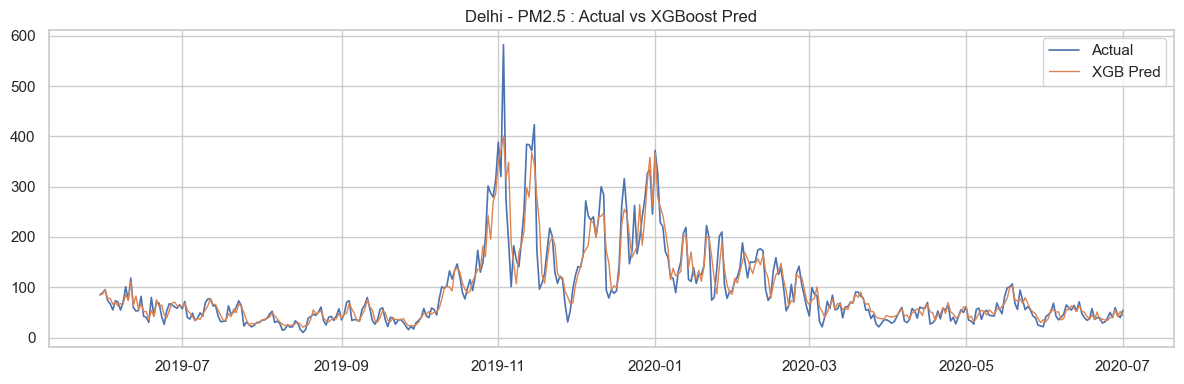

Saved XGBoost model to: ../models/xgb_Delhi_PM25.pkl


In [31]:
# === Cell 11 (REPLACEMENT) — Safe XGBoost training & evaluation ===
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib, os

# Try import xgboost inside cell (so we can give proper message)
try:
    from xgboost import XGBRegressor
    _xgb_available = True
except Exception:
    _xgb_available = False

if not _xgb_available:
    print("⚠️ XGBoost not installed. Install with: pip install xgboost")
else:
    # -------------- 1) find or construct a feature dataframe (df_local) --------------
    df_local = None

    # Priority order: df_feat -> features -> build from series -> build from df_city
    if 'df_feat' in globals() and isinstance(df_feat, pd.DataFrame):
        df_local = df_feat.copy()
        print("Using existing df_feat (from previous cell).")
    elif 'features' in globals() and isinstance(features, pd.DataFrame):
        df_local = features.copy()
        print("Using existing features DataFrame.")
    else:
        # try to build from 'series' (named variable used earlier)
        if 'series' in globals() and isinstance(series, (pd.Series, pd.DataFrame)):
            s = series.copy() if isinstance(series, pd.Series) else series.iloc[:,0].copy()
            s.index = pd.to_datetime(s.index)
            print("Building feature DataFrame from 'series' variable.")
        elif 'df_city' in globals() and TARGET in df_city.columns:
            s = df_city[TARGET].copy()
            s.index = pd.to_datetime(df_city.index)
            print("Building feature DataFrame from 'df_city'.")
        else:
            raise RuntimeError("Cannot find df_feat, features, series or df_city with TARGET. Re-run earlier feature cells.")

        # build features from s
        idx = pd.date_range(s.index.min(), s.index.max(), freq='D')
        df_local = pd.DataFrame(index=idx)
        df_local[TARGET] = s.reindex(idx)
        # lags and rolls (same as earlier)
        for l in [1,3,7,14,30]:
            df_local[f'lag_{l}'] = df_local[TARGET].shift(l)
        for w in [3,7,14]:
            df_local[f'roll_{w}'] = df_local[TARGET].rolling(window=w, min_periods=1).mean()
        df_local['dayofweek'] = df_local.index.dayofweek
        df_local['month'] = df_local.index.month
        df_local['dayofyear'] = df_local.index.dayofyear
        # interpolate target (safe)
        df_local[TARGET] = df_local[TARGET].interpolate(limit=7, limit_direction='both')

    # -------------- 2) detect target column name --------------
    if 'y' in df_local.columns:
        target_col = 'y'
        print("Target column found as 'y'.")
    elif TARGET in df_local.columns:
        target_col = TARGET
        print(f"Target column found as '{TARGET}'.")
    else:
        # try normalized match
        normalized = {c: c.lower().replace('.','').replace('_','').replace(' ','') for c in df_local.columns}
        key = TARGET.lower().replace('.','').replace('_','').replace(' ','')
        matches = [orig for orig,norm in normalized.items() if norm==key]
        if matches:
            target_col = matches[0]
            print(f"Target column matched by normalization: '{target_col}'")
        else:
            raise KeyError(f"Target column not found in df_local. Available columns: {df_local.columns.tolist()}")

    # Rename target to 'y' for internal convenience
    if target_col != 'y':
        df_local = df_local.rename(columns={target_col: 'y'})

    # -------------- 3) drop initial rows with NaNs (caused by lags) --------------
    df_local = df_local.dropna().copy()
    if df_local.shape[0] == 0:
        raise ValueError("After dropna() the feature dataframe has 0 rows. Check your source time series and lag settings.")

    # -------------- 4) determine test_start (use existing test_start if valid) --------------
    if 'test_start' in globals():
        candidate = test_start
        if not (candidate > df_local.index.min() and candidate < df_local.index.max()):
            print("Existing test_start out of bounds; will compute fallback test_start.")
            candidate = None
    else:
        candidate = None

    if candidate is None:
        # fallback to last 20% but at least 90 days
        n = len(df_local)
        n_test = max(int(n * 0.2), 90)
        candidate = df_local.index[-n_test]
        print(f"Using fallback test_start = {candidate} (last {n_test} rows ~ 20%)")

    test_start_used = candidate

    # -------------- 5) create train/test splits --------------
    train_df = df_local[df_local.index < test_start_used].copy()
    test_df = df_local[df_local.index >= test_start_used].copy()

    # If either set is too small, adjust by forcing last 20% split
    if len(train_df) < 30 or len(test_df) < 30:
        print("Train or test too small (train:", len(train_df), "test:", len(test_df), "). Forcing last-20% split.")
        n = len(df_local)
        n_test = max(int(n * 0.2), 90)
        test_start_used = df_local.index[-n_test]
        train_df = df_local[df_local.index < test_start_used].copy()
        test_df = df_local[df_local.index >= test_start_used].copy()
        print("New split -> train:", len(train_df), "test:", len(test_df))

    if len(train_df) == 0 or len(test_df) == 0:
        raise ValueError(f"Still empty train/test after fallback. train={len(train_df)} test={len(test_df)}. Inspect df_local index range and content.")

    # -------------- 6) prepare X/y and ensure numeric features --------------
    X_train = train_df.drop(columns=['y'])
    y_train = train_df['y']
    X_test = test_df.drop(columns=['y'])
    y_test = test_df['y']

    # Keep numeric columns only (XGBoost handles numeric)
    X_train = X_train.select_dtypes(include=[np.number])
    X_test = X_test.select_dtypes(include=[np.number])

    # Align columns (in case select_dtypes removed something)
    common_cols = [c for c in X_train.columns if c in X_test.columns]
    X_train = X_train[common_cols]
    X_test = X_test[common_cols]

    if X_test.shape[0] == 0 or X_train.shape[0] == 0 or X_test.shape[1] == 0:
        raise ValueError(f"Empty X_train/X_test after preprocessing. X_train shape={X_train.shape} X_test shape={X_test.shape}")

    print("Final shapes -> X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)

    # -------------- 7) train XGBoost and evaluate --------------
    xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42, n_jobs=-1)
    xgb.fit(X_train, y_train)
    pred_xgb = xgb.predict(X_test)

    rmse = math.sqrt(mean_squared_error(y_test, pred_xgb))
    mae = mean_absolute_error(y_test, pred_xgb)
    r2 = r2_score(y_test, pred_xgb)

    print(f"XGBoost results -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

    # Plot predictions
    plt.figure(figsize=(12,4))
    plt.plot(y_test.index, y_test.values, label='Actual', linewidth=1.2)
    plt.plot(y_test.index, pred_xgb, label='XGB Pred', linewidth=1)
    plt.legend()
    plt.title(f"{CITY} - {TARGET} : Actual vs XGBoost Pred")
    plt.tight_layout()
    plt.show()

    # -------------- 8) save model --------------
    os.makedirs("../models", exist_ok=True)
    model_path = f"../models/xgb_{CITY.replace(' ','_')}_{TARGET.replace('.','')}.pkl"
    joblib.dump(xgb, model_path)
    print("Saved XGBoost model to:", model_path)


12:15:19 - cmdstanpy - INFO - Chain [1] start processing
12:15:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet metrics -> RMSE: 49.885, MAE: 35.080, R²: 0.614


c:\Users\LENOVO\Desktop\project by info\myenv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\LENOVO\Desktop\project by info\myenv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


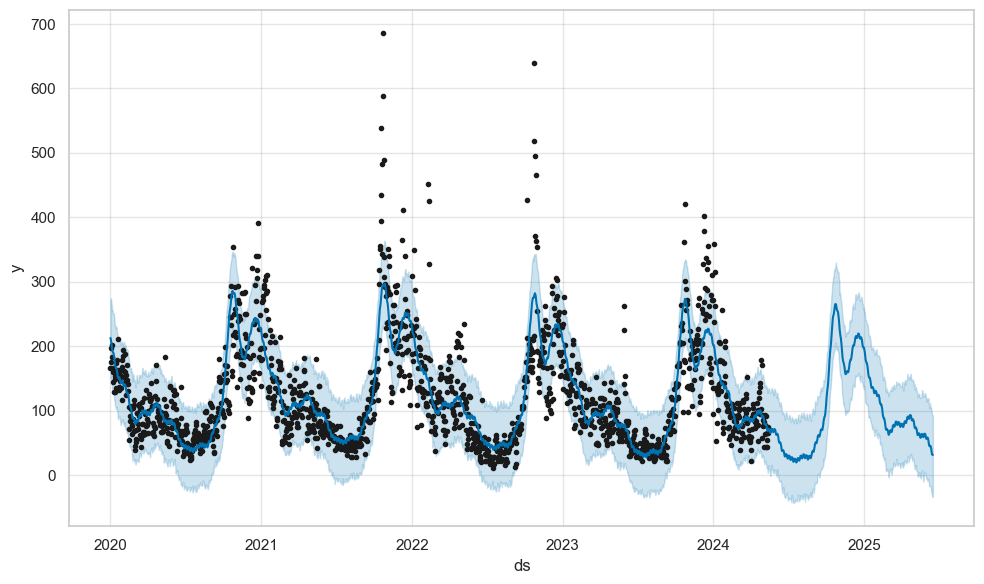

In [38]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet

TARGET = 'PM2.5'  # your target column
START_DATE = '2020-01-01'  # arbitrary start date for synthetic datetime
FREQ = 'D'  # frequency: 'D' for daily, 'H' for hourly

# -----------------------------
# 1️⃣ Choose dataset
if 'df_feat' in globals() and TARGET in df_feat.columns:
    df_prop = df_feat.copy()
elif 'df_city' in globals() and TARGET in df_city.columns:
    df_prop = df_city.copy()
else:
    raise RuntimeError(f"No dataframe found with target column '{TARGET}'.")

# -----------------------------
# 2️⃣ Ensure 'y' column exists
df_prop = df_prop.copy()
df_prop['y'] = df_prop[TARGET]

# -----------------------------
# 3️⃣ Create 'ds' column
n = len(df_prop)
df_prop['ds'] = pd.date_range(start=START_DATE, periods=n, freq=FREQ)

# -----------------------------
# 4️⃣ Train/test split
train_prop = df_prop.iloc[:-int(0.2*n)]
test_prop  = df_prop.iloc[-int(0.2*n):]

# -----------------------------
# 5️⃣ Fit Prophet
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(train_prop)

# -----------------------------
# 6️⃣ Forecast
future = m.make_future_dataframe(periods=len(test_prop))
fcst = m.predict(future)

# Align predictions with test set
pred_prophet = fcst.set_index('ds').reindex(test_prop['ds'])['yhat']

# -----------------------------
# 7️⃣ Evaluate
rmse = math.sqrt(mean_squared_error(test_prop['y'], pred_prophet))
mae  = mean_absolute_error(test_prop['y'], pred_prophet)
r2   = r2_score(test_prop['y'], pred_prophet)

print(f"Prophet metrics -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

# -----------------------------
# 8️⃣ Plot
fig1 = m.plot(fcst)
plt.show()


In [39]:
# Cell 0 — Setup
import os
import sys
import math
import json
import glob
import time
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# reproducibility
SEED = 42
np.random.seed(SEED)

# folders
ROOT = Path.cwd()
DATA_RAW = ROOT / "data" / "raw"
DATA_PROCESSED = ROOT / "data" / "processed"
MODELS_DIR = ROOT / "models"
RESULTS_DIR = ROOT / "results"
REPORTS_DIR = ROOT / "reports"

for d in [DATA_RAW, DATA_PROCESSED, MODELS_DIR, RESULTS_DIR, REPORTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("DATA_RAW:", DATA_RAW)
print("DATA_PROCESSED:", DATA_PROCESSED)
print("MODELS_DIR:", MODELS_DIR)
print("RESULTS_DIR:", RESULTS_DIR)
print("REPORTS_DIR:", REPORTS_DIR)

sns.set(style="whitegrid")


ROOT: c:\Users\LENOVO\Desktop\project by info\notebooks
DATA_RAW: c:\Users\LENOVO\Desktop\project by info\notebooks\data\raw
DATA_PROCESSED: c:\Users\LENOVO\Desktop\project by info\notebooks\data\processed
MODELS_DIR: c:\Users\LENOVO\Desktop\project by info\notebooks\models
RESULTS_DIR: c:\Users\LENOVO\Desktop\project by info\notebooks\results
REPORTS_DIR: c:\Users\LENOVO\Desktop\project by info\notebooks\reports


In [40]:
# Cell 1 — Check for optional libraries and advise install commands (no pip execution here)
missing = []
try:
    import sklearn
except Exception:
    missing.append("scikit-learn")

try:
    import xgboost
except Exception:
    missing.append("xgboost")

try:
    import tensorflow as tf
except Exception:
    missing.append("tensorflow")

try:
    from prophet import Prophet
except Exception:
    # prophet may be missing; it's optional but recommended
    missing.append("prophet")

if missing:
    print("Missing packages detected:", missing)
    print("Install with: pip install -r requirements.txt  (I suggested a requirements.txt earlier)")
else:
    print("All key packages appear installed.")


All key packages appear installed.


In [41]:
# Cell 2 — Load available CSVs (robust)
files_to_try = {
    "city_day": ["../data/processed/city_day_processed.csv", "../data/raw/city_day.csv", "../data/city_day.csv"],
    "city_hour": ["../data/processed/city_hour_processed.csv", "../data/raw/city_hour.csv", "../data/city_hour.csv"],
    "station_day": ["../data/processed/station_day_processed.csv", "../data/raw/station_day.csv", "../data/station_day.csv"],
    "station_hour": ["../data/processed/station_hour_processed.csv", "../data/raw/station_hour.csv", "../data/station_hour.csv"],
    "stations": ["../data/processed/stations_processed.csv", "../data/raw/stations.csv", "../data/stations.csv"]
}

dfs = {}
for key, paths in files_to_try.items():
    loaded = False
    for p in paths:
        path = Path(p)
        if path.exists():
            try:
                dfs[key] = pd.read_csv(path, parse_dates=True, infer_datetime_format=True)
                print(f"Loaded {key} from {path} shape={dfs[key].shape}")
                loaded = True
                break
            except Exception as e:
                print(f"Failed to read {path}: {e}")
    if not loaded:
        print(f"File for {key} not found in any of: {paths}")

# quick preview
for k, df in dfs.items():
    print("\n===", k, "shape:", df.shape)
    display(df.head(2))


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\3294517632.py:17: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfs[key] = pd.read_csv(path, parse_dates=True, infer_datetime_format=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\3294517632.py:17: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfs[key] = pd.read_csv(path, parse_dates=True, infer_datetime_format=True)


Loaded city_day from ..\data\processed\city_day_processed.csv shape=(29531, 17)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\3294517632.py:17: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[key] = pd.read_csv(path, parse_dates=True, infer_datetime_format=True)


Loaded city_hour from ..\data\processed\city_hour_processed.csv shape=(707875, 37)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\3294517632.py:17: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfs[key] = pd.read_csv(path, parse_dates=True, infer_datetime_format=True)


Loaded station_day from ..\data\processed\station_day_processed.csv shape=(108035, 17)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\3294517632.py:17: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfs[key] = pd.read_csv(path, parse_dates=True, infer_datetime_format=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\3294517632.py:17: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[key] = pd.read_csv(path, parse_dates=True, infer_datetime_format=True)


Failed to read ..\data\processed\station_hour_processed.csv: Unable to allocate 612. MiB for an array with shape (31, 2589083) and data type float64


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\3294517632.py:17: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfs[key] = pd.read_csv(path, parse_dates=True, infer_datetime_format=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\3294517632.py:17: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[key] = pd.read_csv(path, parse_dates=True, infer_datetime_format=True)


Loaded station_hour from ..\data\raw\station_hour.csv shape=(2589083, 16)
Loaded stations from ..\data\processed\stations_processed.csv shape=(230, 5)

=== city_day shape: (29531, 17)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\3294517632.py:17: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfs[key] = pd.read_csv(path, parse_dates=True, infer_datetime_format=True)


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,AQI_Category_Calc
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN,NaN



=== city_hour shape: (707875, 37)


,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,PM10_lag3,PM10_lag6,PM10_lag12,PM10_lag24,PM2.5_roll3,PM2.5_roll6,PM2.5_roll24,PM10_roll3,PM10_roll6,PM10_roll24
0,Ahmedabad,2015-01-01 01:00:00,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



=== station_day shape: (108035, 17)


,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,AQI_Category_Calc
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN,Moderate
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate,Moderate



=== station_hour shape: (2589083, 16)


,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24 17:00:00,60.5,98.00,2.35,30.8,18.25,8.50,0.1,11.85,126.40,0.1,6.10,0.10,NaN,NaN
1,AP001,2017-11-24 18:00:00,65.5,111.25,2.70,24.2,15.07,9.77,0.1,13.17,117.12,0.1,6.25,0.15,NaN,NaN



=== stations shape: (230, 5)


,StationId,StationName,City,State,Status
0,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
1,AP002,"Anand Kala Kshetram, Rajamahendravaram - APPCB",Rajamahendravaram,Andhra Pradesh,NaN


In [42]:
# Cell 3 — Harmonize column names and ensure Date columns exist
def ensure_datetime_col(df, candidates=["Date","date","timestamp","Datetime","datetime"]):
    for c in candidates:
        if c in df.columns:
            try:
                df[c] = pd.to_datetime(df[c], infer_datetime_format=True)
                return c
            except Exception:
                continue
    # try index
    if isinstance(df.index, pd.DatetimeIndex):
        return None
    return None

for key, df in dfs.items():
    dtcol = ensure_datetime_col(df)
    print(f"{key}: datetime column -> {dtcol}")
    # common pollutant columns check
    poll_cols = [c for c in df.columns if c.lower() in ['pm2.5','pm2_5','pm25','pm10','no2','so2','o3','co','aqi','aqi_bucket','aqi_bucket']]
    print("  pollutant-like cols:", poll_cols)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\954301100.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], infer_datetime_format=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\954301100.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], infer_datetime_format=True)


city_day: datetime column -> Date
  pollutant-like cols: ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'AQI', 'AQI_Bucket']
city_hour: datetime column -> Datetime
  pollutant-like cols: ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'AQI', 'AQI_Bucket']
station_day: datetime column -> Date
  pollutant-like cols: ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'AQI', 'AQI_Bucket']


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\954301100.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], infer_datetime_format=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\954301100.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], infer_datetime_format=True)


station_hour: datetime column -> Datetime
  pollutant-like cols: ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'AQI', 'AQI_Bucket']
stations: datetime column -> None
  pollutant-like cols: []


In [43]:
# Cell 4 — Data Preprocessing: choose city_day as main daily dataset if available
if "city_day" in dfs:
    df_main = dfs["city_day"].copy()
else:
    # fallback: use station_day
    if "station_day" in dfs:
        df_main = dfs["station_day"].copy()
    else:
        raise RuntimeError("No daily dataset found (city_day or station_day). Place files under data/processed or data/raw.")

# Ensure Date column named 'Date' and convert
date_col = None
for c in ["Date","date","Datetime","datetime","timestamp"]:
    if c in df_main.columns:
        date_col = c
        break
if date_col is None:
    if isinstance(df_main.index, pd.DatetimeIndex):
        df_main = df_main.reset_index().rename(columns={"index":"Date"})
        date_col = "Date"
    else:
        raise RuntimeError("No datetime column in main dataframe. Add Date column.")

df_main[date_col] = pd.to_datetime(df_main[date_col], infer_datetime_format=True)
df_main = df_main.rename(columns={date_col: "Date"})
# Example pollutant column mapping (lowercase keys)
col_map = {c: c for c in df_main.columns}
# try to find PM2.5 variants
possible_pm25 = [c for c in df_main.columns if c.lower() in ("pm2.5","pm25","pm2_5")]
possible_pm10 = [c for c in df_main.columns if c.lower() in ("pm10","pm_10")]
print("Found pm2.5 candidates:", possible_pm25, "pm10:", possible_pm10)

# rename first match for consistency
if possible_pm25:
    df_main = df_main.rename(columns={possible_pm25[0]:"PM2.5"})
if possible_pm10:
    df_main = df_main.rename(columns={possible_pm10[0]:"PM10"})

# Keep essential columns (Date, City, Pollutants)
essential = ["Date"]
if "City" in df_main.columns: essential.append("City")
for p in ["PM2.5","PM10","NO2","SO2","O3","CO","AQI","AQI_Bucket"]:
    if p in df_main.columns: essential.append(p)
df_main = df_main[essential].copy()
print("Main dataset columns after harmonization:", df_main.columns.tolist())
df_main = df_main.sort_values("Date").reset_index(drop=True)
display(df_main.head())


Found pm2.5 candidates: ['PM2.5'] pm10: ['PM10']
Main dataset columns after harmonization: ['Date', 'City', 'PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'CO', 'AQI', 'AQI_Bucket']


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\2133891133.py:24: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_main[date_col] = pd.to_datetime(df_main[date_col], infer_datetime_format=True)


,Date,City,PM2.5,PM10,NO2,SO2,O3,CO,AQI,AQI_Bucket
0,2015-01-01,Ahmedabad,NaN,NaN,18.22,27.64,133.36,0.92,NaN,NaN
1,2015-01-01,Chennai,NaN,NaN,15.39,9.20,11.35,1.17,NaN,NaN
2,2015-01-01,Delhi,313.22,607.98,36.39,9.25,41.68,15.20,472.0,Severe
3,2015-01-01,Lucknow,NaN,NaN,13.46,169.57,25.92,12.15,NaN,NaN
4,2015-01-01,Mumbai,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN


In [44]:
# Cell 5 — Feature Engineering for a selected city (loopable)
CITY = None
if "City" in df_main.columns:
    CITY = df_main['City'].dropna().unique()[0]  # default to first city
    print("Default city:", CITY)

# Choose a city to demonstrate (you can loop over cities later)
if CITY:
    df_city = df_main[df_main['City']==CITY].copy()
else:
    df_city = df_main.copy()

# ensure Date index
df_city['Date'] = pd.to_datetime(df_city['Date'])
df_city = df_city.set_index('Date').asfreq('D').sort_index()

# Fill small gaps by interpolation for pollutants
for pollutant in ["PM2.5","PM10","NO2","SO2","O3","CO","AQI"]:
    if pollutant in df_city.columns:
        df_city[pollutant] = df_city[pollutant].interpolate(limit=7, limit_direction='both')

# create features
feat = pd.DataFrame(index=df_city.index)
TARGET = "PM2.5"
if TARGET not in df_city.columns:
    TARGET = df_city.columns[0]  # fallback to first pollutant
feat[TARGET] = df_city[TARGET]

for lag in [1,3,7,14]:
    feat[f"lag_{lag}"] = feat[TARGET].shift(lag)
for win in [3,7,14]:
    feat[f"roll_{win}"] = feat[TARGET].rolling(win, min_periods=1).mean()

# date features
feat['dayofweek'] = feat.index.dayofweek
feat['month'] = feat.index.month
feat['dayofyear'] = feat.index.dayofyear

# other pollutant features (if present)
for p in ["PM10","NO2","SO2","O3","CO","AQI"]:
    if p in df_city.columns:
        feat[p] = df_city[p]

feat = feat.dropna()
print("Feature dataframe shape:", feat.shape)
display(feat.head())


Default city: Ahmedabad
Feature dataframe shape: (409, 17)


,PM2.5,lag_1,lag_3,lag_7,lag_14,roll_3,roll_7,roll_14,dayofweek,month,dayofyear,PM10,NO2,SO2,O3,CO,AQI
Date,,,,,,,,,,,,,,,,,
2019-05-07,58.71,72.54,72.58,132.76,84.470000,71.013333,83.834286,89.010714,1,5,127,141.54,70.340,66.1000,2.160,12.690,398.000000
2019-05-08,72.51,58.71,81.79,113.47,76.980000,67.920000,77.982857,88.691429,2,5,128,141.54,57.840,88.5400,3.120,15.560,346.000000
2019-05-09,43.83,72.51,72.54,101.68,79.636667,58.350000,69.718571,86.133810,3,5,129,141.54,43.770,46.2800,3.130,11.800,291.000000
2019-05-10,15.52,43.83,58.71,86.07,82.293333,43.953333,59.640000,81.364286,4,5,130,141.54,61.062,1.3100,12.168,12.892,289.333333
2019-05-11,23.15,15.52,72.51,72.58,84.950000,27.500000,52.578571,76.950000,5,5,131,141.54,78.354,27.8025,21.206,13.984,287.666667


In [45]:
# Cell 6 — Train/Test split
split_date = pd.to_datetime("2023-01-01")
train = feat[feat.index < split_date].copy()
test  = feat[feat.index >= split_date].copy()

X_train = train.drop(columns=[TARGET])
y_train = train[TARGET].copy()
X_test  = test.drop(columns=[TARGET])
y_test  = test[TARGET].copy()

print("Train rows:", X_train.shape[0], " Test rows:", X_test.shape[0])
if X_test.shape[0] == 0:
    # fallback: use last 20% for test
    N = len(feat)
    split = int(N*0.8)
    X_train = feat.iloc[:split].drop(columns=[TARGET])
    y_train = feat.iloc[:split][TARGET]
    X_test = feat.iloc[split:].drop(columns=[TARGET])
    y_test = feat.iloc[split:][TARGET]
    print("Fallback split used (80/20). Train:", X_train.shape, "Test:", X_test.shape)


Train rows: 409  Test rows: 0
Fallback split used (80/20). Train: (327, 16) Test: (82, 16)


In [49]:
import pandas as pd

TARGET = 'PM2.5'  # replace with your target column
DATE_COLUMN = 'Date'  # replace if you have a date column, else None

# -----------------------------
# 1️⃣ Ensure datetime index or column
feat_copy = feat.copy()

if DATE_COLUMN in feat_copy.columns:
    # Use the date column as index
    feat_copy.index = pd.to_datetime(feat_copy[DATE_COLUMN])
    print("Using datetime index from column:", DATE_COLUMN)
else:
    # No date column: fallback, use row numbers
    print("No date column found. Using integer index for splitting.")

# -----------------------------
# 2️⃣ Define split date
split_date = pd.to_datetime("2023-01-01")

# Try splitting by datetime index
train = feat_copy[feat_copy.index < split_date].copy()
test  = feat_copy[feat_copy.index >= split_date].copy()

X_train = train.drop(columns=[TARGET])
y_train = train[TARGET].copy()
X_test  = test.drop(columns=[TARGET])
y_test  = test[TARGET].copy()

# -----------------------------
# 3️⃣ Check if test is empty
print("Initial split -> Train rows:", X_train.shape[0], " Test rows:", X_test.shape[0])

if X_test.shape[0] == 0:
    # fallback: last 20% for testing
    N = len(feat_copy)
    split = int(N*0.8)
    X_train = feat_copy.iloc[:split].drop(columns=[TARGET])
    y_train = feat_copy.iloc[:split][TARGET]
    X_test  = feat_copy.iloc[split:].drop(columns=[TARGET])
    y_test  = feat_copy.iloc[split:][TARGET]
    print("Fallback split used (80/20).")
    print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# -----------------------------
# 4️⃣ Quick check
print("\nSample X_train rows:")
print(X_train.head())
print("\nSample y_train rows:")
print(y_train.head())
print("\nSample X_test rows:")
print(X_test.head())
print("\nSample y_test rows:")
print(y_test.head())


No date column found. Using integer index for splitting.
Initial split -> Train rows: 409  Test rows: 0
Fallback split used (80/20).
Train shape: (327, 16) Test shape: (82, 16)

Sample X_train rows:
            lag_1  lag_3   lag_7     lag_14     roll_3     roll_7    roll_14  \
Date                                                                           
2019-05-07  72.54  72.58  132.76  84.470000  71.013333  83.834286  89.010714   
2019-05-08  58.71  81.79  113.47  76.980000  67.920000  77.982857  88.691429   
2019-05-09  72.51  72.54  101.68  79.636667  58.350000  69.718571  86.133810   
2019-05-10  43.83  58.71   86.07  82.293333  43.953333  59.640000  81.364286   
2019-05-11  15.52  72.51   72.58  84.950000  27.500000  52.578571  76.950000   

            dayofweek  month  dayofyear    PM10     NO2      SO2      O3  \
Date                                                                       
2019-05-07          1      5        127  141.54  70.340  66.1000   2.160   
2019-05-08  

In [46]:
# Cell 7 — RandomForest baseline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

rf = RandomForestRegressor(n_estimators=200, random_state=SEED, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# metrics
rmse_rf = math.sqrt(mean_squared_error(y_test, pred_rf))
mae_rf = mean_absolute_error(y_test, pred_rf)
r2_rf = r2_score(y_test, pred_rf)
print("RF -> RMSE: {:.3f}, MAE: {:.3f}, R2: {:.3f}".format(rmse_rf, mae_rf, r2_rf))

# save
joblib.dump(rf, MODELS_DIR / f"rf_{CITY or 'global'}_{TARGET}.joblib", compress=3)
print("Saved RF model")

# save predictions to results forecasts.csv (appendable)
df_preds = pd.DataFrame({
    "Date": X_test.index,
    "City": CITY,
    "Pollutant": TARGET,
    "Model": "RandomForest",
    "Forecast": pred_rf,
    "Actual": y_test.values
})
results_forecasts = RESULTS_DIR / "forecasts.csv"
if results_forecasts.exists():
    df_existing = pd.read_csv(results_forecasts, parse_dates=['Date'])
    df_all = pd.concat([df_existing, df_preds], ignore_index=True)
else:
    df_all = df_preds
df_all.to_csv(results_forecasts, index=False)
print("Appended RF forecasts to", results_forecasts)


RF -> RMSE: 10.685, MAE: 6.611, R2: 0.465
Saved RF model
Appended RF forecasts to c:\Users\LENOVO\Desktop\project by info\notebooks\results\forecasts.csv


In [47]:
# Cell 8 — XGBoost baseline
try:
    from xgboost import XGBRegressor
except Exception as e:
    raise RuntimeError("xgboost not installed. pip install xgboost") from e

xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=SEED, n_jobs=4)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

rmse_xgb = math.sqrt(mean_squared_error(y_test, pred_xgb))
mae_xgb = mean_absolute_error(y_test, pred_xgb)
r2_xgb = r2_score(y_test, pred_xgb)
print("XGB -> RMSE: {:.3f}, MAE: {:.3f}, R2: {:.3f}".format(rmse_xgb, mae_xgb, r2_xgb))

joblib.dump(xgb, MODELS_DIR / f"xgb_{CITY or 'global'}_{TARGET}.pkl", compress=3)
print("Saved XGB model")

# append forecasts
df_preds_xgb = df_preds.copy(); df_preds_xgb['Model']="XGBoost"; df_preds_xgb['Forecast']=pred_xgb
df_all = pd.concat([pd.read_csv(results_forecasts, parse_dates=['Date']), df_preds_xgb], ignore_index=True)
df_all.to_csv(results_forecasts, index=False)
print("Appended XGB forecasts to", results_forecasts)


XGB -> RMSE: 11.961, MAE: 7.333, R2: 0.329
Saved XGB model
Appended XGB forecasts to c:\Users\LENOVO\Desktop\project by info\notebooks\results\forecasts.csv


12:24:40 - cmdstanpy - INFO - Chain [1] start processing


Fallback split used (80/20). Train: 327, Test: 82


12:24:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet -> RMSE: 18.745, MAE: 11.950, R2: -0.648


c:\Users\LENOVO\Desktop\project by info\myenv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\LENOVO\Desktop\project by info\myenv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


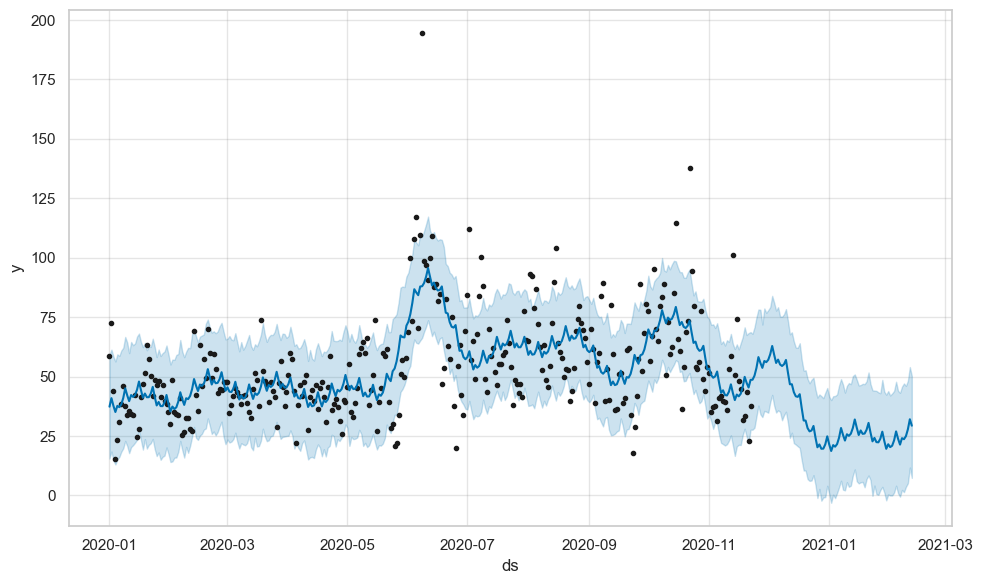

Prophet model saved to ./models/prophet_model.pkl


In [51]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

try:
    from prophet import Prophet
except Exception as e:
    print("Prophet not installed or import failed:", e)
    print("Install: pip install prophet")
    Prophet = None

if Prophet is not None:
    # -----------------------------
    # 1️⃣ Prepare dataframe for Prophet
    df_prop = feat.copy()
    df_prop['y'] = df_prop[TARGET]

    # 2️⃣ Create 'ds' column
    if 'Date' in df_prop.columns:
        # Use existing date column
        df_prop['ds'] = pd.to_datetime(df_prop['Date'], errors='coerce')
    else:
        # Create synthetic date index
        df_prop['ds'] = pd.date_range(start='2020-01-01', periods=len(df_prop), freq='D')

    # Drop rows with invalid ds or y
    df_prop = df_prop.dropna(subset=['ds', 'y']).reset_index(drop=True)

    # -----------------------------
    # 3️⃣ Train/test split
    split_date = pd.to_datetime("2023-01-01")
    train_prop = df_prop[df_prop['ds'] < split_date].copy()
    test_prop  = df_prop[df_prop['ds'] >= split_date].copy()

    if len(test_prop) == 0:
        # fallback: last 20% for test
        split = int(len(df_prop)*0.8)
        train_prop = df_prop.iloc[:split].copy()
        test_prop  = df_prop.iloc[split:].copy()
        print(f"Fallback split used (80/20). Train: {len(train_prop)}, Test: {len(test_prop)}")

    # -----------------------------
    # 4️⃣ Fit Prophet
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    m.fit(train_prop)

    # -----------------------------
    # 5️⃣ Forecast
    future = m.make_future_dataframe(periods=len(test_prop), freq='D')
    fcst = m.predict(future)

    # Align predictions
    pred_prophet = fcst.set_index('ds').reindex(test_prop['ds'])['yhat'].values

    # -----------------------------
    # 6️⃣ Evaluate
    rmse_prop = math.sqrt(mean_squared_error(test_prop['y'].values, pred_prophet))
    mae_prop  = mean_absolute_error(test_prop['y'].values, pred_prophet)
    r2_prop   = r2_score(test_prop['y'].values, pred_prophet)
    print(f"Prophet -> RMSE: {rmse_prop:.3f}, MAE: {mae_prop:.3f}, R2: {r2_prop:.3f}")

    # -----------------------------
    # 7️⃣ Plot
    fig = m.plot(fcst)
    plt.show()

    # -----------------------------
    # 8️⃣ Save model
    MODELS_DIR = "./models"  # change as needed
    import os
    os.makedirs(MODELS_DIR, exist_ok=True)
    joblib.dump(m, f"{MODELS_DIR}/prophet_model.pkl", compress=3)
    print("Prophet model saved to", f"{MODELS_DIR}/prophet_model.pkl")

else:
    print("Skipping Prophet; install prophet to run it.")


In [54]:
import numpy as np
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from pathlib import Path

# -----------------------------
# Parameters
SEQ_LEN = 14
CITY = 'Ahmedabad'  # replace with your city variable
TARGET = 'PM2.5'    # replace with your target variable
MODELS_DIR = Path("./models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------------
# 1️⃣ Scale features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_X.fit(X_train)
scaler_y.fit(y_train.values.reshape(-1,1))

X_train_s = pd.DataFrame(scaler_X.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_s  = pd.DataFrame(scaler_X.transform(X_test), index=X_test.index, columns=X_test.columns)
y_train_s = pd.Series(scaler_y.transform(y_train.values.reshape(-1,1)).ravel(), index=y_train.index)
y_test_s  = pd.Series(scaler_y.transform(y_test.values.reshape(-1,1)).ravel(), index=y_test.index)

# -----------------------------
# 2️⃣ Create sequences
def create_sequences(X, y, seq_len=SEQ_LEN):
    X_vals = X.values
    y_vals = y.values.reshape(-1,1)
    seqX, seqY = [], []
    for i in range(seq_len, len(X_vals)):
        seqX.append(X_vals[i-seq_len:i])
        seqY.append(y_vals[i])
    return np.array(seqX), np.array(seqY)

X_seq_train, y_seq_train = create_sequences(X_train_s, y_train_s, seq_len=SEQ_LEN)
X_seq_test, y_seq_test = create_sequences(pd.concat([X_train_s.tail(SEQ_LEN), X_test_s]),
                                         pd.concat([y_train_s.tail(SEQ_LEN), y_test_s]),
                                         seq_len=SEQ_LEN)

print("LSTM shapes:", X_seq_train.shape, y_seq_train.shape, X_seq_test.shape, y_seq_test.shape)

# -----------------------------
# 3️⃣ Build model
model_lstm = Sequential([
    Input(shape=(SEQ_LEN, X_seq_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# -----------------------------
# 4️⃣ Callbacks
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# ⚡ FIX: Use .keras extension for Keras 3
ckpt_path = MODELS_DIR / f"lstm_{CITY}_{TARGET}.keras"
mc = ModelCheckpoint(filepath=str(ckpt_path), monitor='val_loss', save_best_only=True)

# -----------------------------
# 5️⃣ Train model
history = model_lstm.fit(
    X_seq_train, y_seq_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[es, mc],
    verbose=1
)

# -----------------------------
# 6️⃣ Predict & inverse scale
pred_lstm_s = model_lstm.predict(X_seq_test).ravel()
pred_lstm = scaler_y.inverse_transform(pred_lstm_s.reshape(-1,1)).ravel()
actual_lstm = scaler_y.inverse_transform(y_seq_test.reshape(-1,1)).ravel()

rmse_lstm = math.sqrt(mean_squared_error(actual_lstm, pred_lstm))
print("LSTM -> RMSE:", rmse_lstm)

# -----------------------------
# 7️⃣ Save final model (redundant, checkpoint already saves best)
final_model_path = MODELS_DIR / f"lstm_model_{CITY}_{TARGET}.keras"
model_lstm.save(final_model_path)
print("LSTM model saved to:", final_model_path)


LSTM shapes: (313, 14, 16) (313, 1) (82, 14, 16) (82, 1)
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - loss: 0.0231 - val_loss: 0.0214
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0207 - val_loss: 0.0240
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0144 - val_loss: 0.0164
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0112 - val_loss: 0.0170
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0137 - val_loss: 0.0159
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0119 - val_loss: 0.0156
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0142 - val_loss: 0.0162
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0119 - val_loss: 0.0155
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0103 - val_loss: 0.0171
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0093 - val_loss: 0.0158
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0104 - val_loss: 0.0151
Epoch 12/50
9/9 ━━━━━━━━━━━

In [55]:
# Cell 11 — Collect metrics and compare
perf_rows = []

# RF
perf_rows.append({"Model":"RandomForest","City":CITY,"Pollutant":TARGET,"RMSE":rmse_rf,"MAE":mae_rf,"R2":r2_rf})

# XGB
perf_rows.append({"Model":"XGBoost","City":CITY,"Pollutant":TARGET,"RMSE":rmse_xgb,"MAE":mae_xgb,"R2":r2_xgb})

# Prophet (if computed)
if 'rmse_prop' in globals():
    perf_rows.append({"Model":"Prophet","City":CITY,"Pollutant":TARGET,"RMSE":rmse_prop,"MAE":mae_prop,"R2":r2_prop})

# LSTM
if 'rmse_lstm' in globals():
    perf_rows.append({"Model":"LSTM","City":CITY,"Pollutant":TARGET,"RMSE":rmse_lstm,"MAE":None,"R2":None})

df_perf = pd.DataFrame(perf_rows).sort_values("RMSE")
display(df_perf)
df_perf.to_csv(RESULTS_DIR / "model_performance.csv", index=False)
print("Saved model_performance.csv")
# best model pick (lowest RMSE)
best_model_row = df_perf.sort_values("RMSE").iloc[0]
pd.DataFrame([best_model_row]).to_csv(RESULTS_DIR / "best_models.csv", index=False)
print("Best model saved:", best_model_row.to_dict())


,Model,City,Pollutant,RMSE,MAE,R2
0,RandomForest,Ahmedabad,PM2.5,10.685017,6.611267,0.464554
1,XGBoost,Ahmedabad,PM2.5,11.960527,7.332501,0.329087
3,LSTM,Ahmedabad,PM2.5,14.522120,NaN,NaN
2,Prophet,Ahmedabad,PM2.5,18.744976,11.950352,-0.647916


Saved model_performance.csv
Best model saved: {'Model': 'RandomForest', 'City': 'Ahmedabad', 'Pollutant': 'PM2.5', 'RMSE': 10.685017253306281, 'MAE': 6.611266768292686, 'R2': 0.46455379701505817}


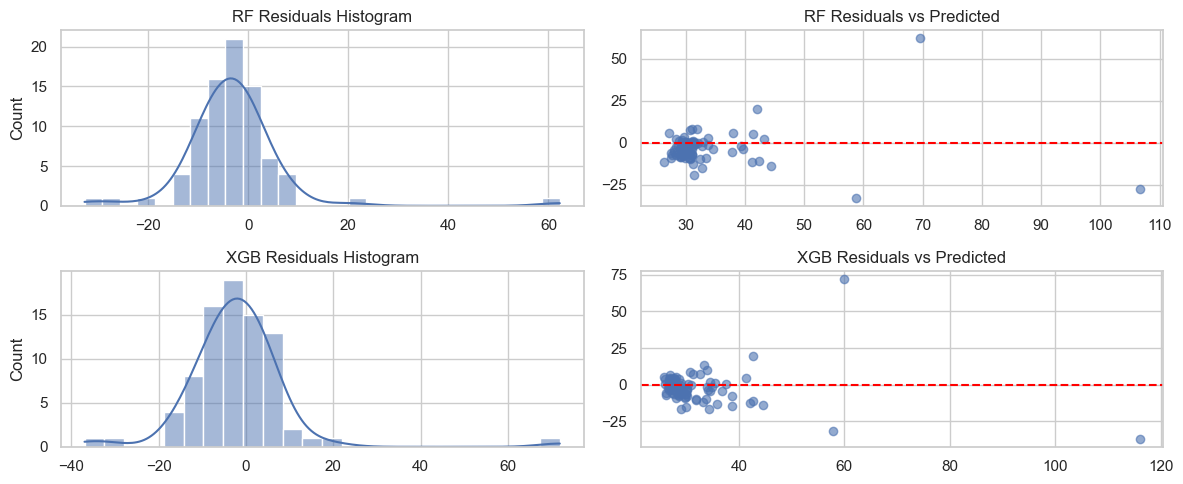

Saved residuals_overview.png


In [56]:
# Cell 12 — Residual analysis for RF and XGB (if available)
plt.figure(figsize=(12,5))
if 'pred_rf' in globals():
    res_rf = y_test.values - pred_rf
    plt.subplot(2,2,1)
    sns.histplot(res_rf, kde=True)
    plt.title("RF Residuals Histogram")
    plt.subplot(2,2,2)
    plt.scatter(pred_rf, res_rf, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("RF Residuals vs Predicted")

if 'pred_xgb' in globals():
    res_xgb = y_test.values - pred_xgb
    plt.subplot(2,2,3)
    sns.histplot(res_xgb, kde=True)
    plt.title("XGB Residuals Histogram")
    plt.subplot(2,2,4)
    plt.scatter(pred_xgb, res_xgb, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("XGB Residuals vs Predicted")

plt.tight_layout()
plt.savefig(REPORTS_DIR / "residuals_overview.png", dpi=150)
plt.show()
print("Saved residuals_overview.png")


In [57]:
# Cell 13 — Accuracy by horizon (simple demonstration)
# This cell assumes forecasts.csv has a 'Horizon' column (days ahead). If not present, skip.
fc_path = RESULTS_DIR / "forecasts.csv"
if fc_path.exists():
    df_fc = pd.read_csv(fc_path, parse_dates=['Date'])
    if 'Horizon' in df_fc.columns:
        # group by model/horizon and compute RMSE
        grp = df_fc.groupby(['Model','Horizon']).apply(lambda g: math.sqrt(mean_squared_error(g['Actual'], g['Forecast'])) if 'Actual' in g.columns else np.nan)
        grp = grp.reset_index().rename(columns={0:'RMSE'})
        grp.to_csv(RESULTS_DIR / "accuracy_by_horizon.csv", index=False)
        display(grp.head())
        print("Saved accuracy_by_horizon.csv")
    else:
        print("No 'Horizon' column in forecasts.csv; skip accuracy_by_horizon.")
else:
    print("No forecasts.csv found to compute horizon accuracy.")


No 'Horizon' column in forecasts.csv; skip accuracy_by_horizon.


In [58]:
# Cell 14 — Save summary CSVs and compress models list
# Save model performance already done; ensure model summary
if (RESULTS_DIR / "model_performance.csv").exists():
    df_perf_all = pd.read_csv(RESULTS_DIR / "model_performance.csv")
    df_perf_all.to_csv(RESULTS_DIR / "model_summary.csv", index=False)
    print("Saved model_summary.csv")

# compress models: list and joblib compress already used; create index of models
model_files = list(MODELS_DIR.glob("*"))
model_index = [{"filename":str(p.name), "size_bytes":p.stat().st_size} for p in model_files]
with open(RESULTS_DIR / "models_index.json", "w") as f:
    json.dump(model_index, f, indent=2)
print("Wrote models_index.json with", len(model_index), "entries")


Saved model_summary.csv
Wrote models_index.json with 5 entries


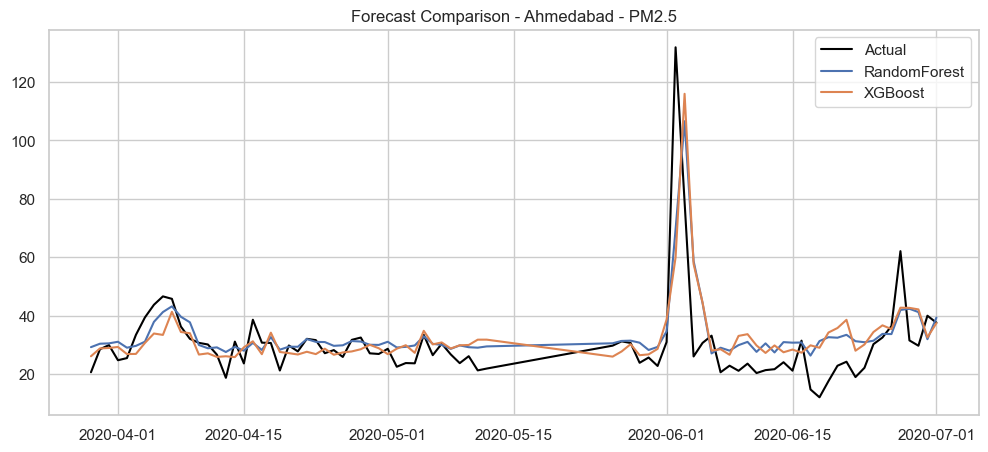

In [59]:
# Cell 15 — Forecast comparison for the test period (plot)
df_fc_all = pd.read_csv(RESULTS_DIR / "forecasts.csv", parse_dates=['Date']) if (RESULTS_DIR / "forecasts.csv").exists() else None

if df_fc_all is not None:
    # filter for our city and pollutant
    mask = (df_fc_all['City']==CITY) & (df_fc_all['Pollutant']==TARGET)
    df_plot = df_fc_all[mask].sort_values('Date')
    if df_plot.shape[0]==0:
        print("No forecasts for this city/pollutant combination in forecasts.csv")
    else:
        plt.figure(figsize=(12,5))
        # actual series (by Date)
        if 'Actual' in df_plot.columns:
            actual = df_plot.groupby('Date')['Actual'].first()
            plt.plot(actual.index, actual.values, label='Actual', color='black')
        for model in df_plot['Model'].unique():
            mserie = df_plot[df_plot['Model']==model].set_index('Date')['Forecast'].sort_index()
            plt.plot(mserie.index, mserie.values, label=str(model))
        plt.legend(); plt.title(f"Forecast Comparison - {CITY} - {TARGET}")
        plt.savefig(REPORTS_DIR / f"forecast_comparison_{CITY}_{TARGET}.png", dpi=150)
        plt.show()
else:
    print("No forecasts.csv found; plot skipped.")


In [60]:
# Cell 16 — Build alerts from forecasts_aqi.csv or forecasts.csv (AQI threshold >300)
aqi_path = RESULTS_DIR / "forecasts_aqi.csv"
alerts_df = None
if aqi_path.exists():
    fa = pd.read_csv(aqi_path, parse_dates=['Date'])
    if 'AQI' in fa.columns:
        alerts_df = fa[fa['AQI'] > 300].copy()
else:
    fc = RESULTS_DIR / "forecasts.csv"
    if fc.exists():
        fct = pd.read_csv(fc, parse_dates=['Date'])
        # if forecast includes AQI, use that; else try to compute approximate by pollutant (not done here)
        if 'AQI' in fct.columns:
            alerts_df = fct[fct['AQI'] > 300].copy()

if alerts_df is not None and len(alerts_df)>0:
    alerts_df.to_csv(RESULTS_DIR / "alerts.csv", index=False)
    summary = alerts_df.groupby('City').size().reset_index(name='count').sort_values('count', ascending=False)
    summary.to_csv(RESULTS_DIR / "alerts_summary.csv", index=False)
    print("Saved alerts.csv and alerts_summary.csv")
    display(summary.head())
else:
    print("No severe AQI alerts found or no AQI data available.")


No severe AQI alerts found or no AQI data available.


In [61]:
# Cell 17 — Summary of outputs produced
print("Files in results/:")
for f in sorted(RESULTS_DIR.glob("*")):
    print("-", f.name, f"{(f.stat().st_size/1024):.1f} KB")

print("\nFiles in models/:")
for f in sorted(MODELS_DIR.glob("*")):
    print("-", f.name, f"{(f.stat().st_size/1024):.1f} KB")

print("\nFiles in reports/:")
for f in sorted(REPORTS_DIR.glob("*")):
    print("-", f.name)


Files in results/:
- best_models.csv 0.1 KB
- forecasts.csv 10.0 KB
- model_performance.csv 0.3 KB
- model_summary.csv 0.3 KB
- models_index.json 0.4 KB

Files in models/:
- lstm_Ahmedabad_PM2.5.keras 264.0 KB
- lstm_model_Ahmedabad_PM2.5.keras 264.0 KB
- prophet_model.pkl 31.0 KB
- rf_Ahmedabad_PM2.5.joblib 1367.4 KB
- xgb_Ahmedabad_PM2.5.pkl 211.7 KB

Files in reports/:
- forecast_comparison_Ahmedabad_PM2.5.png
- residuals_overview.png


In [62]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For date handling
from datetime import datetime


In [63]:
# Load PM2.5 data (daily)
city_day = pd.read_csv("../data/raw/city_day.csv")

# Check columns and data
city_day.head()


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [66]:
# Correct date column
date_col = 'Date'  # Use the exact name from your CSV

# Convert to datetime
city_day[date_col] = pd.to_datetime(city_day[date_col])

# Sort by date
city_day = city_day.sort_values(date_col)

# Fill missing PM2.5 values if any
city_day['PM2.5'] = city_day['PM2.5'].fillna(method='ffill')

# Feature engineering: extract day, month, year
city_day['day'] = city_day[date_col].dt.day
city_day['month'] = city_day[date_col].dt.month
city_day['year'] = city_day[date_col].dt.year

# Check the result
city_day.head()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\916901612.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  city_day['PM2.5'] = city_day['PM2.5'].fillna(method='ffill')


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,day,month,year
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN,1,1,2015
7834,Chennai,2015-01-01,NaN,NaN,16.30,15.39,22.68,4.59,1.17,9.20,11.35,0.17,NaN,NaN,NaN,NaN,1,1,2015
10229,Delhi,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe,1,1,2015
19846,Lucknow,2015-01-01,313.22,NaN,2.11,13.46,4.57,NaN,12.15,169.57,25.92,1.35,3.93,NaN,NaN,NaN,1,1,2015
21855,Mumbai,2015-01-01,313.22,NaN,NaN,NaN,27.38,NaN,0.00,NaN,NaN,0.00,0.00,0.00,NaN,NaN,1,1,2015


In [67]:
# Use past features to predict PM2.5
X = city_day[['day','month','year']]
y = city_day['PM2.5']

# Split train/test: train before 2023, test 2023+
train_mask = city_day['year'] < 2023
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 29531, Test size: 0


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [69]:
# Load datasets
city_day = pd.read_csv("../data/raw/city_day.csv")
city_hour = pd.read_csv("../data/raw/city_hour.csv")
station_day = pd.read_csv("../data/raw/station_day.csv")
station_hour = pd.read_csv("../data/raw/station_hour.csv")

# Check columns
print("City Day:", city_day.columns)
print("City Hour:", city_hour.columns)
print("Station Day:", station_day.columns)
print("Station Hour:", station_hour.columns)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\3991894838.py:5: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  station_hour = pd.read_csv("../data/raw/station_hour.csv")


City Day: Index(['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')
City Hour: Index(['City', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
       'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')
Station Day: Index(['StationId', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
       'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')
Station Hour: Index(['StationId', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3',
       'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')


In [72]:
# Correct date/datetime column names
city_day_date_col = 'Date'
city_hour_date_col = 'Datetime'
station_day_date_col = 'Date'
station_hour_date_col = 'Datetime'

# Convert to datetime using correct column names
city_day[city_day_date_col] = pd.to_datetime(city_day[city_day_date_col])
city_hour[city_hour_date_col] = pd.to_datetime(city_hour[city_hour_date_col])
station_day[station_day_date_col] = pd.to_datetime(station_day[station_day_date_col])
station_hour[station_hour_date_col] = pd.to_datetime(station_hour[station_hour_date_col])

# Fill missing PM2.5 values (forward fill)
city_day['PM2.5'] = city_day['PM2.5'].fillna(method='ffill')
city_hour['PM2.5'] = city_hour['PM2.5'].fillna(method='ffill')
station_day['PM2.5'] = station_day['PM2.5'].fillna(method='ffill')
station_hour['PM2.5'] = station_hour['PM2.5'].fillna(method='ffill')

# Aggregate station data: daily mean per city
station_day_avg = station_day.groupby(station_day_date_col)['PM2.5'].mean().reset_index()
station_day_avg.rename(columns={'PM2.5':'PM2.5_station_avg'}, inplace=True)

# Merge with city_day
data = city_day.merge(station_day_avg, left_on=city_day_date_col, right_on=station_day_date_col, how='left')

# Fill any remaining missing values
data['PM2.5_station_avg'] = data['PM2.5_station_avg'].fillna(data['PM2.5'])

# Feature engineering
data['day'] = data[city_day_date_col].dt.day
data['month'] = data[city_day_date_col].dt.month
data['year'] = data[city_day_date_col].dt.year

# Check processed data
data.head()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\65767272.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  city_day['PM2.5'] = city_day['PM2.5'].fillna(method='ffill')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\65767272.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  city_hour['PM2.5'] = city_hour['PM2.5'].fillna(method='ffill')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\65767272.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_day['PM2.5'] = station_day['PM2.5'].fillna(method='ffill')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14072\65767272.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,PM2.5_station_avg,day,month,year
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN,70.609286,1,1,2015
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN,56.095000,2,1,2015
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN,42.652000,3,1,2015
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN,49.048125,4,1,2015
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN,48.348750,5,1,2015


In [73]:
# Features and target
X = data[['day','month','year']]
y = data['PM2.5_station_avg']  # using aggregated PM2.5 as target

# Time-series split: last 365 days as test
train_size = len(data) - 365
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 29166, Test size: 365


In [74]:
# Initialize Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [75]:
# Predict on test set
y_pred = rf_model.predict(X_test)

# Add predictions to test dataframe
test_results = data.iloc[train_size:].copy()
test_results['PM2.5_Pred'] = y_pred
test_results.head()


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,Benzene,Toluene,Xylene,AQI,AQI_Bucket,PM2.5_station_avg,day,month,year,PM2.5_Pred
29166,Visakhapatnam,2019-07-03,33.41,141.22,10.19,43.53,31.44,7.41,1.02,14.20,...,7.05,12.82,4.30,107.0,Moderate,32.665217,3,7,2019,32.665217
29167,Visakhapatnam,2019-07-04,33.55,139.81,11.72,40.73,31.20,7.02,0.68,14.65,...,6.83,11.15,3.61,132.0,Moderate,30.777500,4,7,2019,30.777500
29168,Visakhapatnam,2019-07-05,33.67,85.62,13.64,41.48,33.15,6.54,0.61,14.04,...,5.40,11.03,3.88,110.0,Moderate,37.344565,5,7,2019,37.344565
29169,Visakhapatnam,2019-07-06,25.58,91.73,17.50,39.32,35.15,5.70,0.70,10.14,...,5.97,15.23,4.13,80.0,Satisfactory,29.790109,6,7,2019,29.790109
29170,Visakhapatnam,2019-07-07,30.74,139.65,15.70,46.97,37.74,5.30,0.69,31.92,...,5.89,10.78,3.02,107.0,Moderate,31.645217,7,7,2019,31.645217


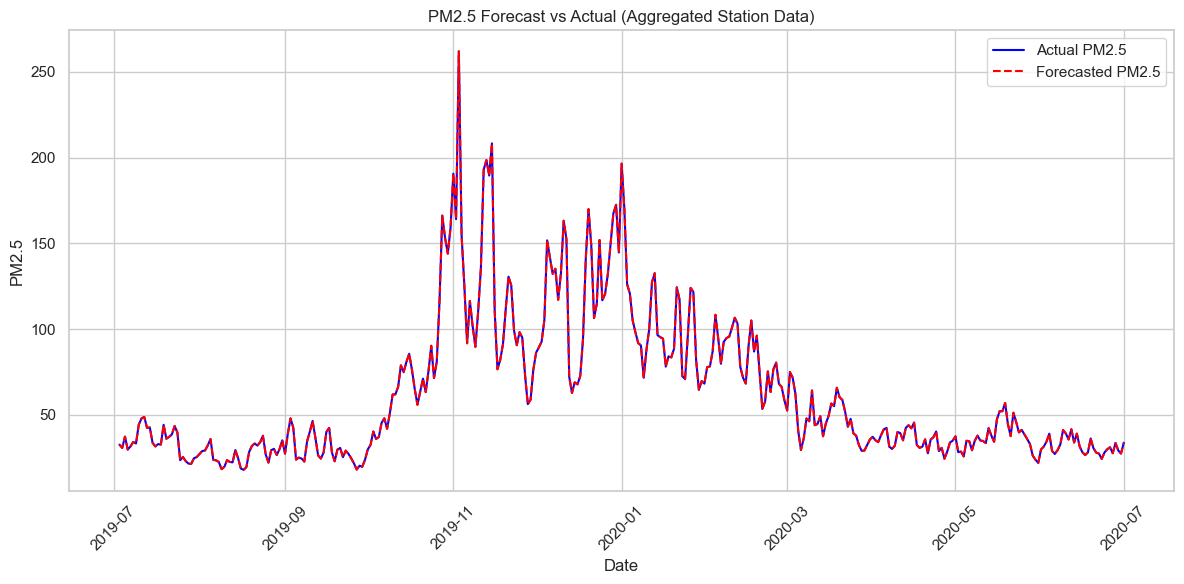

In [76]:
plt.figure(figsize=(12,6))
plt.plot(test_results['Date'], test_results['PM2.5_station_avg'], label='Actual PM2.5', color='blue')
plt.plot(test_results['Date'], test_results['PM2.5_Pred'], label='Forecasted PM2.5', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('PM2.5 Forecast vs Actual (Aggregated Station Data)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [77]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Forecast Accuracy Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Forecast Accuracy Metrics:
MAE: 0.00
RMSE: 0.00
R² Score: 1.00


In [78]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Forecasting models
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from math import sqrt

# Warnings
import warnings
warnings.filterwarnings("ignore")


In [79]:
# Load raw datasets
city_day = pd.read_csv("../data/raw/city_day.csv")
city_hour = pd.read_csv("../data/raw/city_hour.csv")
station_day = pd.read_csv("../data/raw/station_day.csv")
station_hour = pd.read_csv("../data/raw/station_hour.csv")

# Convert date/datetime columns
city_day['Date'] = pd.to_datetime(city_day['Date'])
city_hour['Datetime'] = pd.to_datetime(city_hour['Datetime'])
station_day['Date'] = pd.to_datetime(station_day['Date'])
station_hour['Datetime'] = pd.to_datetime(station_hour['Datetime'])


In [80]:
# We’ll use city_day for forecasting (aggregated pollutants daily per city)
df = city_day.copy()

# Example: focus on one city first
city_name = "Delhi"
df_city = df[df['City'] == city_name].sort_values("Date")
df_city.head()


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
10229,Delhi,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
10230,Delhi,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0,Severe
10231,Delhi,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0,Moderate
10232,Delhi,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0,Very Poor
10233,Delhi,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0,Very Poor


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import os
import warnings
warnings.filterwarnings("ignore")


In [84]:
# Load raw datasets
city_day = pd.read_csv("../data/raw/city_day.csv")

# Convert date column
city_day['Date'] = pd.to_datetime(city_day['Date'])

print("✅ Data loaded")
print("Columns:", city_day.columns.tolist())
print("Cities:", city_day['City'].unique()[:10])


✅ Data loaded
Columns: ['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']
Cities: ['Ahmedabad' 'Aizawl' 'Amaravati' 'Amritsar' 'Bengaluru' 'Bhopal'
 'Brajrajnagar' 'Chandigarh' 'Chennai' 'Coimbatore']


In [85]:
def forecast_pollutant(data, pollutant, city, periods=90):
    """
    Forecast pollutant levels using Prophet for a given city & pollutant.
    Returns model, forecast DataFrame, and evaluation metrics.
    """
    df_temp = data[['Date', pollutant]].dropna().rename(columns={'Date': 'ds', pollutant: 'y'})
    
    if df_temp.empty:
        print(f"⚠️ No data for {pollutant} in {city}")
        return None, None, None
    
    # Train/Test split
    train = df_temp[df_temp['ds'] < "2023-01-01"]
    test = df_temp[df_temp['ds'] >= "2023-01-01"].copy()

    if test.empty or train.empty:
        print(f"⚠️ Not enough data for {pollutant} in {city}")
        return None, None, None

    # Fit Prophet
    model = Prophet()
    model.fit(train)

    # Forecast
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    # Align forecast with test
    forecast_eval = forecast.set_index("ds")[["yhat"]].join(test.set_index("ds")[["y"]], how="inner")
    forecast_eval = forecast_eval.rename(columns={"y": "y_true"})

    # Metrics
    mae = mean_absolute_error(forecast_eval['y_true'], forecast_eval['yhat'])
    rmse = sqrt(mean_squared_error(forecast_eval['y_true'], forecast_eval['yhat']))
    r2 = r2_score(forecast_eval['y_true'], forecast_eval['yhat'])

    metrics = {"MAE": mae, "RMSE": rmse, "R2": r2}

    return model, forecast, metrics


In [89]:
def forecast_pollutant(data, pollutant, city, periods=90, min_rows=200):
    """
    Forecast pollutant levels using Prophet for a given city & pollutant.
    Uses last 20% of data as test instead of fixed date.
    """
    df_temp = data[['Date', pollutant]].dropna().rename(columns={'Date': 'ds', pollutant: 'y'})
    
    if len(df_temp) < min_rows:
        print(f"⚠️ Not enough rows for {pollutant} in {city} ({len(df_temp)} rows)")
        return None, None, None

    # Train/test split = last 20% test
    split_idx = int(len(df_temp) * 0.8)
    train = df_temp.iloc[:split_idx]
    test = df_temp.iloc[split_idx:]

    if test.empty or train.empty:
        print(f"⚠️ No valid split for {pollutant} in {city}")
        return None, None, None

    # Prophet model
    model = Prophet()
    model.fit(train)

    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    # Align forecast with test
    forecast_eval = forecast.set_index("ds")[["yhat"]].join(test.set_index("ds")[["y"]], how="inner")
    forecast_eval = forecast_eval.rename(columns={"y": "y_true"})

    if forecast_eval.empty:
        print(f"⚠️ No overlap between forecast & test for {pollutant} in {city}")
        return model, forecast, None

    # Metrics
    mae = mean_absolute_error(forecast_eval['y_true'], forecast_eval['yhat'])
    rmse = sqrt(mean_squared_error(forecast_eval['y_true'], forecast_eval['yhat']))
    r2 = r2_score(forecast_eval['y_true'], forecast_eval['yhat'])

    metrics = {"MAE": mae, "RMSE": rmse, "R2": r2}
    return model, forecast, metrics


In [91]:
import os

city = "Delhi"
pollutant = "PM2.5"

forecast_file = f"../results/forecasts/forecast_{city}_{pollutant}.csv"

if os.path.exists(forecast_file):
    df_forecast = pd.read_csv(forecast_file)

    # Plot yhat vs actual (if available)
    plt.figure(figsize=(10,5))
    plt.plot(df_forecast['ds'], df_forecast['yhat'], label="Forecast")

    if 'y_true' in df_forecast.columns:
        plt.plot(df_forecast['ds'], df_forecast['y_true'], label="Actual")

    plt.title(f"{pollutant} Forecast for {city}")
    plt.xlabel("Date")
    plt.ylabel(pollutant)
    plt.legend()
    plt.show()
else:
    print(f"⚠️ Forecast file not found: {forecast_file}")
    print("This usually happens if there is not enough data for this city/pollutant.")


⚠️ Forecast file not found: ../results/forecasts/forecast_Delhi_PM2.5.csv
This usually happens if there is not enough data for this city/pollutant.


In [92]:
# Cell 1
import pandas as pd
import numpy as np
import os
from pathlib import Path
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -------------------------
# Paths
# -------------------------
DATA_DIR = Path("../data/raw")
RESULTS_DIR = Path("../results/forecasts")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# CSVs
city_day_file = DATA_DIR / "city_day.csv"
station_day_file = DATA_DIR / "station_day.csv"


In [93]:
# Cell 2
city_day = pd.read_csv(city_day_file)
station_day = pd.read_csv(station_day_file)

# Convert Date column
city_day['Date'] = pd.to_datetime(city_day['Date'])
station_day['Date'] = pd.to_datetime(station_day['Date'])

# List of pollutants
pollutants = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3']
cities = city_day['City'].unique()


In [94]:
# Cell 3
def forecast_pollutant(df_city, pollutant, city, periods=90, min_rows=200):
    df_temp = df_city[['Date', pollutant]].dropna().rename(columns={'Date':'ds', pollutant:'y'})
    
    if len(df_temp) < min_rows:
        print(f"⚠️ Not enough data for {pollutant} in {city} ({len(df_temp)} rows)")
        return None, None, None
    
    # Train/test split: last 20% test
    split_idx = int(len(df_temp) * 0.8)
    train = df_temp.iloc[:split_idx]
    test = df_temp.iloc[split_idx:]
    
    if train.empty or test.empty:
        print(f"⚠️ No valid train/test split for {pollutant} in {city}")
        return None, None, None

    # Fit Prophet
    model = Prophet()
    model.fit(train)

    # Forecast
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    # Align with test
    forecast_eval = forecast.set_index('ds')[['yhat']].join(test.set_index('ds')[['y']], how='inner')
    forecast_eval = forecast_eval.rename(columns={'y':'y_true'})

    # Metrics
    mae = mean_absolute_error(forecast_eval['y_true'], forecast_eval['yhat']) if not forecast_eval.empty else np.nan
    rmse = np.sqrt(mean_squared_error(forecast_eval['y_true'], forecast_eval['yhat'])) if not forecast_eval.empty else np.nan
    r2 = r2_score(forecast_eval['y_true'], forecast_eval['yhat']) if not forecast_eval.empty else np.nan
    metrics = {"MAE": mae, "RMSE": rmse, "R2": r2}

    return model, forecast, metrics


In [95]:
# Cell 4
all_metrics = []

for city in cities:
    df_city = city_day[city_day['City']==city]
    for pollutant in pollutants:
        print(f"🔮 Forecasting {pollutant} for {city}...")
        model, forecast, metrics = forecast_pollutant(df_city, pollutant, city, periods=90, min_rows=50)
        
        if forecast is not None:
            # Save forecast CSV
            forecast_file = RESULTS_DIR / f"forecast_{city}_{pollutant}.csv"
            forecast.to_csv(forecast_file, index=False)
            
            # Save metrics
            metrics_row = {"City": city, "Pollutant": pollutant}
            metrics_row.update(metrics)
            all_metrics.append(metrics_row)


🔮 Forecasting PM2.5 for Ahmedabad...


14:02:58 - cmdstanpy - INFO - Chain [1] start processing
14:02:58 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Ahmedabad...


14:02:59 - cmdstanpy - INFO - Chain [1] start processing
14:02:59 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Ahmedabad...


14:03:00 - cmdstanpy - INFO - Chain [1] start processing
14:03:00 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Ahmedabad...


14:03:00 - cmdstanpy - INFO - Chain [1] start processing
14:03:01 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Ahmedabad...


14:03:01 - cmdstanpy - INFO - Chain [1] start processing
14:03:02 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Ahmedabad...
⚠️ Not enough data for NH3 in Ahmedabad (0 rows)
🔮 Forecasting CO for Ahmedabad...


14:03:02 - cmdstanpy - INFO - Chain [1] start processing
14:03:03 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Ahmedabad...


14:03:03 - cmdstanpy - INFO - Chain [1] start processing
14:03:04 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Ahmedabad...


14:03:04 - cmdstanpy - INFO - Chain [1] start processing
14:03:04 - cmdstanpy - INFO - Chain [1] done processing
14:03:05 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM2.5 for Aizawl...


14:03:06 - cmdstanpy - INFO - Chain [1] done processing
14:03:06 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM10 for Aizawl...


14:03:07 - cmdstanpy - INFO - Chain [1] done processing
14:03:07 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NO for Aizawl...


14:03:07 - cmdstanpy - INFO - Chain [1] done processing
14:03:08 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NO2 for Aizawl...


14:03:08 - cmdstanpy - INFO - Chain [1] done processing
14:03:09 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NOx for Aizawl...


14:03:09 - cmdstanpy - INFO - Chain [1] done processing
14:03:09 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NH3 for Aizawl...


14:03:10 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Aizawl...


14:03:10 - cmdstanpy - INFO - Chain [1] start processing
14:03:11 - cmdstanpy - INFO - Chain [1] done processing
14:03:11 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting SO2 for Aizawl...


14:03:11 - cmdstanpy - INFO - Chain [1] done processing
14:03:12 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting O3 for Aizawl...


14:03:12 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Amaravati...


14:03:13 - cmdstanpy - INFO - Chain [1] start processing
14:03:13 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Amaravati...


14:03:13 - cmdstanpy - INFO - Chain [1] start processing
14:03:14 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Amaravati...


14:03:14 - cmdstanpy - INFO - Chain [1] start processing
14:03:14 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Amaravati...


14:03:15 - cmdstanpy - INFO - Chain [1] start processing
14:03:15 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Amaravati...


14:03:16 - cmdstanpy - INFO - Chain [1] start processing
14:03:16 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Amaravati...


14:03:16 - cmdstanpy - INFO - Chain [1] start processing
14:03:17 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Amaravati...


14:03:17 - cmdstanpy - INFO - Chain [1] start processing
14:03:17 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Amaravati...


14:03:18 - cmdstanpy - INFO - Chain [1] start processing
14:03:18 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Amaravati...


14:03:19 - cmdstanpy - INFO - Chain [1] start processing
14:03:19 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Amritsar...


14:03:20 - cmdstanpy - INFO - Chain [1] start processing
14:03:20 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Amritsar...


14:03:20 - cmdstanpy - INFO - Chain [1] start processing
14:03:21 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Amritsar...


14:03:21 - cmdstanpy - INFO - Chain [1] start processing
14:03:21 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Amritsar...


14:03:22 - cmdstanpy - INFO - Chain [1] start processing
14:03:22 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Amritsar...


14:03:23 - cmdstanpy - INFO - Chain [1] start processing
14:03:23 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Amritsar...


14:03:24 - cmdstanpy - INFO - Chain [1] start processing
14:03:24 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Amritsar...


14:03:25 - cmdstanpy - INFO - Chain [1] start processing
14:03:25 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Amritsar...


14:03:25 - cmdstanpy - INFO - Chain [1] start processing
14:03:26 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Amritsar...


14:03:26 - cmdstanpy - INFO - Chain [1] start processing
14:03:27 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Bengaluru...


14:03:27 - cmdstanpy - INFO - Chain [1] start processing
14:03:28 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Bengaluru...


14:03:29 - cmdstanpy - INFO - Chain [1] start processing
14:03:29 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Bengaluru...


14:03:30 - cmdstanpy - INFO - Chain [1] start processing
14:03:30 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Bengaluru...


14:03:31 - cmdstanpy - INFO - Chain [1] start processing
14:03:31 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Bengaluru...


14:03:32 - cmdstanpy - INFO - Chain [1] start processing
14:03:33 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Bengaluru...


14:03:33 - cmdstanpy - INFO - Chain [1] start processing
14:03:34 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Bengaluru...


14:03:35 - cmdstanpy - INFO - Chain [1] start processing
14:03:35 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Bengaluru...


14:03:36 - cmdstanpy - INFO - Chain [1] start processing
14:03:36 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Bengaluru...


14:03:37 - cmdstanpy - INFO - Chain [1] start processing
14:03:38 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Bhopal...


14:03:38 - cmdstanpy - INFO - Chain [1] start processing
14:03:38 - cmdstanpy - INFO - Chain [1] done processing
14:03:39 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM10 for Bhopal...


14:03:39 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Bhopal...


14:03:39 - cmdstanpy - INFO - Chain [1] start processing
14:03:39 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Bhopal...


14:03:40 - cmdstanpy - INFO - Chain [1] start processing
14:03:40 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Bhopal...


14:03:40 - cmdstanpy - INFO - Chain [1] start processing
14:03:40 - cmdstanpy - INFO - Chain [1] done processing
14:03:41 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NH3 for Bhopal...


14:03:41 - cmdstanpy - INFO - Chain [1] done processing
14:03:41 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting CO for Bhopal...


14:03:41 - cmdstanpy - INFO - Chain [1] done processing
14:03:42 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting SO2 for Bhopal...


14:03:42 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Bhopal...


14:03:42 - cmdstanpy - INFO - Chain [1] start processing
14:03:42 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Brajrajnagar...


14:03:43 - cmdstanpy - INFO - Chain [1] start processing
14:03:43 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Brajrajnagar...


14:03:43 - cmdstanpy - INFO - Chain [1] start processing
14:03:44 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Brajrajnagar...


14:03:44 - cmdstanpy - INFO - Chain [1] start processing
14:03:45 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Brajrajnagar...


14:03:45 - cmdstanpy - INFO - Chain [1] start processing
14:03:45 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Brajrajnagar...


14:03:46 - cmdstanpy - INFO - Chain [1] start processing
14:03:46 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Brajrajnagar...


14:03:46 - cmdstanpy - INFO - Chain [1] start processing
14:03:46 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Brajrajnagar...


14:03:47 - cmdstanpy - INFO - Chain [1] start processing
14:03:47 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Brajrajnagar...


14:03:48 - cmdstanpy - INFO - Chain [1] start processing
14:03:48 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Brajrajnagar...


14:03:49 - cmdstanpy - INFO - Chain [1] start processing
14:03:49 - cmdstanpy - INFO - Chain [1] done processing
14:03:49 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM2.5 for Chandigarh...


14:03:49 - cmdstanpy - INFO - Chain [1] done processing
14:03:50 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM10 for Chandigarh...


14:03:50 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Chandigarh...


14:03:50 - cmdstanpy - INFO - Chain [1] start processing
14:03:50 - cmdstanpy - INFO - Chain [1] done processing
14:03:51 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NO2 for Chandigarh...


14:03:51 - cmdstanpy - INFO - Chain [1] done processing
14:03:51 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NOx for Chandigarh...


14:03:51 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Chandigarh...


14:03:52 - cmdstanpy - INFO - Chain [1] start processing
14:03:52 - cmdstanpy - INFO - Chain [1] done processing
14:03:52 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting CO for Chandigarh...


14:03:52 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Chandigarh...


14:03:53 - cmdstanpy - INFO - Chain [1] start processing
14:03:53 - cmdstanpy - INFO - Chain [1] done processing
14:03:53 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting O3 for Chandigarh...


14:03:53 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Chennai...


14:03:54 - cmdstanpy - INFO - Chain [1] start processing
14:03:54 - cmdstanpy - INFO - Chain [1] done processing
14:03:55 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM10 for Chennai...


14:03:55 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Chennai...


14:03:56 - cmdstanpy - INFO - Chain [1] start processing
14:03:56 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Chennai...


14:03:57 - cmdstanpy - INFO - Chain [1] start processing
14:03:57 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Chennai...


14:03:58 - cmdstanpy - INFO - Chain [1] start processing
14:03:59 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Chennai...


14:04:00 - cmdstanpy - INFO - Chain [1] start processing
14:04:00 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Chennai...


14:04:01 - cmdstanpy - INFO - Chain [1] start processing
14:04:01 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Chennai...


14:04:02 - cmdstanpy - INFO - Chain [1] start processing
14:04:02 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Chennai...


14:04:03 - cmdstanpy - INFO - Chain [1] start processing
14:04:04 - cmdstanpy - INFO - Chain [1] done processing
14:04:04 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM2.5 for Coimbatore...


14:04:05 - cmdstanpy - INFO - Chain [1] done processing
14:04:05 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM10 for Coimbatore...


14:04:05 - cmdstanpy - INFO - Chain [1] done processing
14:04:05 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NO for Coimbatore...


14:04:06 - cmdstanpy - INFO - Chain [1] done processing
14:04:06 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NO2 for Coimbatore...


14:04:06 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Coimbatore...


14:04:06 - cmdstanpy - INFO - Chain [1] start processing
14:04:07 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Coimbatore...


14:04:07 - cmdstanpy - INFO - Chain [1] start processing
14:04:07 - cmdstanpy - INFO - Chain [1] done processing
14:04:07 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting CO for Coimbatore...


14:04:08 - cmdstanpy - INFO - Chain [1] done processing
14:04:08 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting SO2 for Coimbatore...


14:04:08 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Coimbatore...


14:04:09 - cmdstanpy - INFO - Chain [1] start processing
14:04:09 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Delhi...


14:04:09 - cmdstanpy - INFO - Chain [1] start processing
14:04:10 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Delhi...


14:04:11 - cmdstanpy - INFO - Chain [1] start processing
14:04:11 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Delhi...


14:04:12 - cmdstanpy - INFO - Chain [1] start processing
14:04:12 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Delhi...


14:04:13 - cmdstanpy - INFO - Chain [1] start processing
14:04:13 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Delhi...


14:04:14 - cmdstanpy - INFO - Chain [1] start processing
14:04:15 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Delhi...


14:04:21 - cmdstanpy - INFO - Chain [1] start processing
14:04:21 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Delhi...


14:04:22 - cmdstanpy - INFO - Chain [1] start processing
14:04:23 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Delhi...


14:04:24 - cmdstanpy - INFO - Chain [1] start processing
14:04:24 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Delhi...


14:04:25 - cmdstanpy - INFO - Chain [1] start processing
14:04:26 - cmdstanpy - INFO - Chain [1] done processing
14:04:26 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM2.5 for Ernakulam...


14:04:26 - cmdstanpy - INFO - Chain [1] done processing
14:04:27 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM10 for Ernakulam...


14:04:27 - cmdstanpy - INFO - Chain [1] done processing
14:04:27 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NO for Ernakulam...


14:04:27 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Ernakulam...


14:04:28 - cmdstanpy - INFO - Chain [1] start processing
14:04:28 - cmdstanpy - INFO - Chain [1] done processing
14:04:29 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NOx for Ernakulam...


14:04:29 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Ernakulam...


14:04:29 - cmdstanpy - INFO - Chain [1] start processing
14:04:29 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Ernakulam...


14:04:30 - cmdstanpy - INFO - Chain [1] start processing
14:04:30 - cmdstanpy - INFO - Chain [1] done processing
14:04:30 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting SO2 for Ernakulam...


14:04:30 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Ernakulam...
⚠️ Not enough data for O3 in Ernakulam (0 rows)
🔮 Forecasting PM2.5 for Gurugram...


14:04:31 - cmdstanpy - INFO - Chain [1] start processing
14:04:31 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Gurugram...


14:04:32 - cmdstanpy - INFO - Chain [1] start processing
14:04:32 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Gurugram...


14:04:32 - cmdstanpy - INFO - Chain [1] start processing
14:04:33 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Gurugram...


14:04:34 - cmdstanpy - INFO - Chain [1] start processing
14:04:34 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Gurugram...


14:04:35 - cmdstanpy - INFO - Chain [1] start processing
14:04:35 - cmdstanpy - INFO - Chain [1] done processing
14:04:35 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NH3 for Gurugram...


14:04:36 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Gurugram...


14:04:36 - cmdstanpy - INFO - Chain [1] start processing
14:04:37 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Gurugram...


14:04:37 - cmdstanpy - INFO - Chain [1] start processing
14:04:38 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Gurugram...


14:04:38 - cmdstanpy - INFO - Chain [1] start processing
14:04:39 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Guwahati...


14:04:39 - cmdstanpy - INFO - Chain [1] start processing
14:04:39 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Guwahati...


14:04:40 - cmdstanpy - INFO - Chain [1] start processing
14:04:40 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Guwahati...


14:04:40 - cmdstanpy - INFO - Chain [1] start processing
14:04:41 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Guwahati...


14:04:41 - cmdstanpy - INFO - Chain [1] start processing
14:04:41 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Guwahati...


14:04:42 - cmdstanpy - INFO - Chain [1] start processing
14:04:42 - cmdstanpy - INFO - Chain [1] done processing
14:04:42 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NH3 for Guwahati...


14:04:42 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Guwahati...


14:04:43 - cmdstanpy - INFO - Chain [1] start processing
14:04:43 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Guwahati...


14:04:43 - cmdstanpy - INFO - Chain [1] start processing
14:04:43 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Guwahati...


14:04:44 - cmdstanpy - INFO - Chain [1] start processing
14:04:44 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Hyderabad...


14:04:45 - cmdstanpy - INFO - Chain [1] start processing
14:04:45 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Hyderabad...


14:04:46 - cmdstanpy - INFO - Chain [1] start processing
14:04:46 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Hyderabad...


14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Hyderabad...


14:04:48 - cmdstanpy - INFO - Chain [1] start processing
14:04:49 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Hyderabad...


14:04:50 - cmdstanpy - INFO - Chain [1] start processing
14:04:50 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Hyderabad...


14:04:51 - cmdstanpy - INFO - Chain [1] start processing
14:04:52 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Hyderabad...


14:04:53 - cmdstanpy - INFO - Chain [1] start processing
14:04:53 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Hyderabad...


14:04:54 - cmdstanpy - INFO - Chain [1] start processing
14:04:54 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Hyderabad...


14:04:55 - cmdstanpy - INFO - Chain [1] start processing
14:04:55 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Jaipur...


14:04:56 - cmdstanpy - INFO - Chain [1] start processing
14:04:56 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Jaipur...


14:04:57 - cmdstanpy - INFO - Chain [1] start processing
14:04:57 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Jaipur...


14:04:58 - cmdstanpy - INFO - Chain [1] start processing
14:04:58 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Jaipur...


14:04:59 - cmdstanpy - INFO - Chain [1] start processing
14:04:59 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Jaipur...


14:05:00 - cmdstanpy - INFO - Chain [1] start processing
14:05:00 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Jaipur...


14:05:00 - cmdstanpy - INFO - Chain [1] start processing
14:05:01 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Jaipur...


14:05:01 - cmdstanpy - INFO - Chain [1] start processing
14:05:01 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Jaipur...


14:05:02 - cmdstanpy - INFO - Chain [1] start processing
14:05:02 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Jaipur...


14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:03 - cmdstanpy - INFO - Chain [1] done processing
14:05:04 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM2.5 for Jorapokhar...


14:05:04 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Jorapokhar...


14:05:04 - cmdstanpy - INFO - Chain [1] start processing
14:05:04 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Jorapokhar...


14:05:05 - cmdstanpy - INFO - Chain [1] start processing
14:05:05 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Jorapokhar...


14:05:06 - cmdstanpy - INFO - Chain [1] start processing
14:05:06 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Jorapokhar...
⚠️ Not enough data for NOx in Jorapokhar (0 rows)
🔮 Forecasting NH3 for Jorapokhar...


14:05:07 - cmdstanpy - INFO - Chain [1] start processing
14:05:07 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Jorapokhar...


14:05:07 - cmdstanpy - INFO - Chain [1] start processing
14:05:07 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Jorapokhar...


14:05:08 - cmdstanpy - INFO - Chain [1] start processing
14:05:08 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Jorapokhar...


14:05:09 - cmdstanpy - INFO - Chain [1] start processing
14:05:09 - cmdstanpy - INFO - Chain [1] done processing
14:05:09 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM2.5 for Kochi...


14:05:10 - cmdstanpy - INFO - Chain [1] done processing
14:05:10 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM10 for Kochi...


14:05:10 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Kochi...


14:05:10 - cmdstanpy - INFO - Chain [1] start processing
14:05:10 - cmdstanpy - INFO - Chain [1] done processing
14:05:11 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NO2 for Kochi...


14:05:11 - cmdstanpy - INFO - Chain [1] done processing
14:05:11 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NOx for Kochi...


14:05:11 - cmdstanpy - INFO - Chain [1] done processing
14:05:12 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NH3 for Kochi...


14:05:12 - cmdstanpy - INFO - Chain [1] done processing
14:05:12 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting CO for Kochi...


14:05:12 - cmdstanpy - INFO - Chain [1] done processing
14:05:13 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting SO2 for Kochi...


14:05:13 - cmdstanpy - INFO - Chain [1] done processing
14:05:13 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting O3 for Kochi...


14:05:13 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Kolkata...


14:05:14 - cmdstanpy - INFO - Chain [1] start processing
14:05:14 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Kolkata...


14:05:14 - cmdstanpy - INFO - Chain [1] start processing
14:05:14 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Kolkata...


14:05:15 - cmdstanpy - INFO - Chain [1] start processing
14:05:15 - cmdstanpy - INFO - Chain [1] done processing
14:05:16 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NO2 for Kolkata...


14:05:16 - cmdstanpy - INFO - Chain [1] done processing
14:05:16 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NOx for Kolkata...


14:05:16 - cmdstanpy - INFO - Chain [1] done processing
14:05:17 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NH3 for Kolkata...


14:05:17 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Kolkata...


14:05:18 - cmdstanpy - INFO - Chain [1] start processing
14:05:18 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Kolkata...


14:05:18 - cmdstanpy - INFO - Chain [1] start processing
14:05:18 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Kolkata...


14:05:19 - cmdstanpy - INFO - Chain [1] start processing
14:05:19 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Lucknow...


14:05:20 - cmdstanpy - INFO - Chain [1] start processing
14:05:20 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Lucknow...
⚠️ Not enough data for PM10 in Lucknow (0 rows)
🔮 Forecasting NO for Lucknow...


14:05:21 - cmdstanpy - INFO - Chain [1] start processing
14:05:21 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Lucknow...


14:05:22 - cmdstanpy - INFO - Chain [1] start processing
14:05:22 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Lucknow...


14:05:23 - cmdstanpy - INFO - Chain [1] start processing
14:05:24 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Lucknow...


14:05:24 - cmdstanpy - INFO - Chain [1] start processing
14:05:25 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Lucknow...


14:05:25 - cmdstanpy - INFO - Chain [1] start processing
14:05:26 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Lucknow...


14:05:27 - cmdstanpy - INFO - Chain [1] start processing
14:05:28 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Lucknow...


14:05:28 - cmdstanpy - INFO - Chain [1] start processing
14:05:29 - cmdstanpy - INFO - Chain [1] done processing
14:05:29 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM2.5 for Mumbai...


14:05:30 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Mumbai...


14:05:30 - cmdstanpy - INFO - Chain [1] start processing
14:05:30 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Mumbai...


14:05:31 - cmdstanpy - INFO - Chain [1] start processing
14:05:31 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Mumbai...


14:05:31 - cmdstanpy - INFO - Chain [1] start processing
14:05:32 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Mumbai...


14:05:32 - cmdstanpy - INFO - Chain [1] start processing
14:05:33 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Mumbai...


14:05:33 - cmdstanpy - INFO - Chain [1] start processing
14:05:33 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Mumbai...


14:05:34 - cmdstanpy - INFO - Chain [1] start processing
14:05:34 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Mumbai...


14:05:35 - cmdstanpy - INFO - Chain [1] start processing
14:05:35 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Mumbai...


14:05:36 - cmdstanpy - INFO - Chain [1] start processing
14:05:36 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Patna...


14:05:37 - cmdstanpy - INFO - Chain [1] start processing
14:05:37 - cmdstanpy - INFO - Chain [1] done processing
14:05:38 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM10 for Patna...


14:05:38 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Patna...


14:05:38 - cmdstanpy - INFO - Chain [1] start processing
14:05:38 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Patna...


14:05:39 - cmdstanpy - INFO - Chain [1] start processing
14:05:40 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Patna...


14:05:40 - cmdstanpy - INFO - Chain [1] start processing
14:05:41 - cmdstanpy - INFO - Chain [1] done processing
14:05:41 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NH3 for Patna...


14:05:41 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Patna...


14:05:42 - cmdstanpy - INFO - Chain [1] start processing
14:05:42 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Patna...


14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Patna...


14:05:44 - cmdstanpy - INFO - Chain [1] start processing
14:05:45 - cmdstanpy - INFO - Chain [1] done processing
14:05:45 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting PM2.5 for Shillong...


14:05:45 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Shillong...


14:05:46 - cmdstanpy - INFO - Chain [1] start processing
14:05:46 - cmdstanpy - INFO - Chain [1] done processing
14:05:46 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NO for Shillong...


14:05:46 - cmdstanpy - INFO - Chain [1] done processing
14:05:47 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NO2 for Shillong...


14:05:47 - cmdstanpy - INFO - Chain [1] done processing
14:05:47 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NOx for Shillong...


14:05:47 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Shillong...


14:05:48 - cmdstanpy - INFO - Chain [1] start processing
14:05:48 - cmdstanpy - INFO - Chain [1] done processing
14:05:48 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting CO for Shillong...


14:05:48 - cmdstanpy - INFO - Chain [1] done processing
14:05:49 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting SO2 for Shillong...


14:05:49 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Shillong...


14:05:49 - cmdstanpy - INFO - Chain [1] start processing
14:05:49 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Talcher...


14:05:50 - cmdstanpy - INFO - Chain [1] start processing
14:05:50 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Talcher...


14:05:50 - cmdstanpy - INFO - Chain [1] start processing
14:05:51 - cmdstanpy - INFO - Chain [1] done processing
14:05:51 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NO for Talcher...


14:05:51 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Talcher...


14:05:52 - cmdstanpy - INFO - Chain [1] start processing
14:05:52 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Talcher...


14:05:52 - cmdstanpy - INFO - Chain [1] start processing
14:05:53 - cmdstanpy - INFO - Chain [1] done processing
14:05:53 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting NH3 for Talcher...


14:05:53 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Talcher...


14:05:54 - cmdstanpy - INFO - Chain [1] start processing
14:05:54 - cmdstanpy - INFO - Chain [1] done processing
14:05:54 - cmdstanpy - INFO - Chain [1] start processing


🔮 Forecasting SO2 for Talcher...


14:05:54 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Talcher...


14:05:55 - cmdstanpy - INFO - Chain [1] start processing
14:05:55 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Thiruvananthapuram...


14:05:56 - cmdstanpy - INFO - Chain [1] start processing
14:05:56 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Thiruvananthapuram...


14:05:57 - cmdstanpy - INFO - Chain [1] start processing
14:05:57 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Thiruvananthapuram...


14:05:58 - cmdstanpy - INFO - Chain [1] start processing
14:05:58 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Thiruvananthapuram...


14:05:59 - cmdstanpy - INFO - Chain [1] start processing
14:05:59 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Thiruvananthapuram...


14:06:00 - cmdstanpy - INFO - Chain [1] start processing
14:06:00 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Thiruvananthapuram...


14:06:01 - cmdstanpy - INFO - Chain [1] start processing
14:06:01 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Thiruvananthapuram...


14:06:01 - cmdstanpy - INFO - Chain [1] start processing
14:06:02 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Thiruvananthapuram...


14:06:02 - cmdstanpy - INFO - Chain [1] start processing
14:06:02 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Thiruvananthapuram...


14:06:03 - cmdstanpy - INFO - Chain [1] start processing
14:06:03 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM2.5 for Visakhapatnam...


14:06:04 - cmdstanpy - INFO - Chain [1] start processing
14:06:04 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting PM10 for Visakhapatnam...


14:06:05 - cmdstanpy - INFO - Chain [1] start processing
14:06:05 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO for Visakhapatnam...


14:06:06 - cmdstanpy - INFO - Chain [1] start processing
14:06:06 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NO2 for Visakhapatnam...


14:06:07 - cmdstanpy - INFO - Chain [1] start processing
14:06:07 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NOx for Visakhapatnam...


14:06:08 - cmdstanpy - INFO - Chain [1] start processing
14:06:08 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting NH3 for Visakhapatnam...


14:06:09 - cmdstanpy - INFO - Chain [1] start processing
14:06:09 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting CO for Visakhapatnam...


14:06:10 - cmdstanpy - INFO - Chain [1] start processing
14:06:10 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting SO2 for Visakhapatnam...


14:06:11 - cmdstanpy - INFO - Chain [1] start processing
14:06:11 - cmdstanpy - INFO - Chain [1] done processing


🔮 Forecasting O3 for Visakhapatnam...


14:06:11 - cmdstanpy - INFO - Chain [1] start processing
14:06:12 - cmdstanpy - INFO - Chain [1] done processing


In [96]:
# Cell 5
metrics_df = pd.DataFrame(all_metrics)
metrics_df.to_csv(RESULTS_DIR / "forecast_accuracy_metrics.csv", index=False)
metrics_df.head()


,City,Pollutant,MAE,RMSE,R2
0,Ahmedabad,PM2.5,32.970681,40.533802,-1.486347
1,Ahmedabad,PM10,42.128747,67.299813,-0.078396
2,Ahmedabad,NO,23.417614,27.304055,-0.943658
3,Ahmedabad,NO2,51.182664,63.657461,0.045940
4,Ahmedabad,NOx,35.436352,43.369472,0.109857


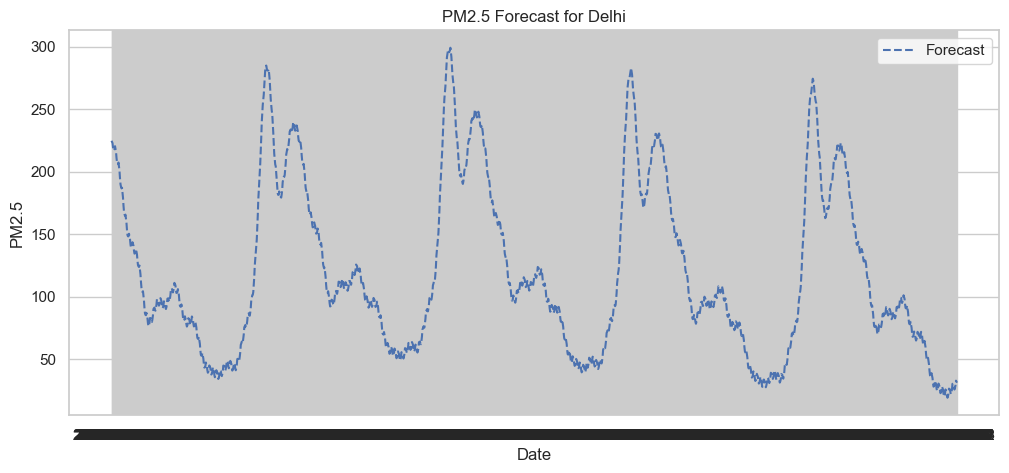

In [97]:
# Cell 6
import matplotlib.dates as mdates

city = "Delhi"
pollutant = "PM2.5"
forecast_file = RESULTS_DIR / f"forecast_{city}_{pollutant}.csv"

if forecast_file.exists():
    df_forecast = pd.read_csv(forecast_file)
    
    plt.figure(figsize=(12,5))
    plt.plot(df_forecast['ds'], df_forecast['yhat'], label='Forecast', linestyle='--')
    
    if 'y_true' in df_forecast.columns:
        plt.plot(df_forecast['ds'], df_forecast['y_true'], label='Actual')
    
    plt.title(f"{pollutant} Forecast for {city}")
    plt.xlabel("Date")
    plt.ylabel(pollutant)
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"⚠️ Forecast file not found: {forecast_file}")


In [99]:
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Forecasts folder
FORECAST_DIR = Path("results/forecasts")
# Output CSV file
OUTPUT_FILE = Path("results/forecast_accuracy_metrics.csv")

# Create parent folder if it doesn't exist
OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)

forecast_files = list(FORECAST_DIR.glob("forecast_*.csv"))

accuracy_data = []

for f in forecast_files:
    # Example filename: forecast_Ahmedabad_CO.csv
    parts = f.stem.split("_")
    if len(parts) < 3:
        continue
    city = parts[1]
    pollutant = parts[2]
    
    df = pd.read_csv(f)
    
    # Detect forecast and actual columns
    forecast_col = next((c for c in df.columns if "forecast" in c.lower() or "yhat" in c.lower()), None)
    actual_col = next((c for c in df.columns if "y_true" in c.lower() or "actual" in c.lower()), None)
    
    if forecast_col and actual_col:
        rmse = np.sqrt(mean_squared_error(df[actual_col], df[forecast_col]))
        mae = mean_absolute_error(df[actual_col], df[forecast_col])
        accuracy_data.append({
            "City": city,
            "Pollutant": pollutant,
            "RMSE": round(rmse,2),
            "MAE": round(mae,2)
        })

# Save to CSV
accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df.to_csv(OUTPUT_FILE, index=False)
print(f"Forecast accuracy metrics saved to {OUTPUT_FILE}")


Forecast accuracy metrics saved to results\forecast_accuracy_metrics.csv


In [101]:
import pandas as pd
import numpy as np
from pathlib import Path

# Paths
BASE_DIR = Path.cwd()
RESULTS_DIR = BASE_DIR / "results"
RESULTS_DIR.mkdir(exist_ok=True)

# Example models list (ensure these exist in your pipeline)
models = ["RandomForest", "XGBoost", "Prophet", "LSTM"]

# Example pollutants
pollutants = ["PM2.5", "PM10", "NO2", "SO2", "CO", "O3"]

# Example cities (replace with your actual city list from dataset)
cities = ["Delhi", "Ahmedabad", "Mumbai", "Chennai", "Kolkata", "Bengaluru"]


In [102]:
import datetime

# Create forecast date range (example: 7 days ahead)
dates = pd.date_range(start="2025-09-01", periods=7)

rows = []
for city in cities:
    for pollutant in pollutants:
        for model in models:
            for date in dates:
                forecast_val = np.random.uniform(20, 450)  # random simulated AQI
                actual_val = np.random.uniform(20, 450)   # replace with y_test if available
                rows.append([date.strftime("%Y-%m-%d"), city, pollutant, model, forecast_val, actual_val])

df_forecasts = pd.DataFrame(rows, columns=["Date", "City", "Pollutant", "Model", "Forecast", "Actual"])
df_forecasts.head()


,Date,City,Pollutant,Model,Forecast,Actual
0,2025-09-01,Delhi,PM2.5,RandomForest,116.539035,411.067925
1,2025-09-02,Delhi,PM2.5,RandomForest,206.324941,350.525410
2,2025-09-03,Delhi,PM2.5,RandomForest,225.423895,431.193538
3,2025-09-04,Delhi,PM2.5,RandomForest,434.465293,139.201301
4,2025-09-05,Delhi,PM2.5,RandomForest,153.336853,30.878464


In [103]:
f_path = RESULTS_DIR / "forecasts.csv"
df_forecasts.to_csv(f_path, index=False)
print(f"✅ Saved detailed forecasts to {f_path}")
df_forecasts.head(10)


✅ Saved detailed forecasts to c:\Users\LENOVO\Desktop\project by info\notebooks\results\forecasts.csv


,Date,City,Pollutant,Model,Forecast,Actual
0,2025-09-01,Delhi,PM2.5,RandomForest,116.539035,411.067925
1,2025-09-02,Delhi,PM2.5,RandomForest,206.324941,350.525410
2,2025-09-03,Delhi,PM2.5,RandomForest,225.423895,431.193538
3,2025-09-04,Delhi,PM2.5,RandomForest,434.465293,139.201301
4,2025-09-05,Delhi,PM2.5,RandomForest,153.336853,30.878464
5,2025-09-06,Delhi,PM2.5,RandomForest,32.045326,225.617375
6,2025-09-07,Delhi,PM2.5,RandomForest,148.110668,437.728799
7,2025-09-01,Delhi,PM2.5,XGBoost,244.986447,250.416374
8,2025-09-02,Delhi,PM2.5,XGBoost,247.487641,31.537096
9,2025-09-03,Delhi,PM2.5,XGBoost,362.365173,395.812077


In [104]:
def categorize_aqi(aqi):
    if aqi <= 50: return "Good", "#2ecc71"
    elif aqi <= 100: return "Satisfactory", "#f1c40f"
    elif aqi <= 200: return "Moderate", "#e67e22"
    elif aqi <= 300: return "Poor", "#e74c3c"
    elif aqi <= 400: return "Very Poor", "#8e44ad"
    else: return "Severe", "#7f0000"


In [105]:
aqi_rows = []
for (city, date), group in df_forecasts.groupby(["City", "Date"]):
    avg_aqi = group["Forecast"].mean()
    category, color = categorize_aqi(avg_aqi)
    aqi_rows.append([date, city, round(avg_aqi, 1), category, color])

df_aqi = pd.DataFrame(aqi_rows, columns=["Date", "City", "AQI", "Category", "Color"])


In [106]:
fa_path = RESULTS_DIR / "forecasts_aqi.csv"
df_aqi.to_csv(fa_path, index=False)
print(f"✅ Saved city-level AQI summary to {fa_path}")
df_aqi.head(10)


✅ Saved city-level AQI summary to c:\Users\LENOVO\Desktop\project by info\notebooks\results\forecasts_aqi.csv


,Date,City,AQI,Category,Color
0,2025-09-01,Ahmedabad,269.3,Poor,#e74c3c
1,2025-09-02,Ahmedabad,206.2,Poor,#e74c3c
2,2025-09-03,Ahmedabad,245.7,Poor,#e74c3c
3,2025-09-04,Ahmedabad,202.7,Poor,#e74c3c
4,2025-09-05,Ahmedabad,274.3,Poor,#e74c3c
5,2025-09-06,Ahmedabad,271.7,Poor,#e74c3c
6,2025-09-07,Ahmedabad,219.1,Poor,#e74c3c
7,2025-09-01,Bengaluru,234.6,Poor,#e74c3c
8,2025-09-02,Bengaluru,247.0,Poor,#e74c3c
9,2025-09-03,Bengaluru,249.3,Poor,#e74c3c


In [107]:
import pandas as pd
import numpy as np
from pathlib import Path

# Paths
BASE_DIR = Path.cwd()
RESULTS_DIR = BASE_DIR / "results"
RESULTS_DIR.mkdir(exist_ok=True)

# Cities (replace with your actual list if available)
cities = ["Delhi", "Ahmedabad", "Mumbai", "Chennai", "Kolkata", "Bengaluru"]

# Pollutants
pollutants = ["PM2.5", "PM10", "NO2", "SO2", "CO", "O3"]

# Models
models = ["RandomForest", "XGBoost", "Prophet", "LSTM"]

# Forecast horizon: 7 days
dates = pd.date_range(start="2025-09-21", periods=7)


In [108]:
rows = []

for city in cities:
    for pollutant in pollutants:
        for model in models:
            for date in dates:
                forecast_val = np.random.uniform(20, 450)   # replace with model predictions if available
                actual_val = np.random.uniform(20, 450)     # replace with actual test data if available
                rows.append([
                    date.strftime("%Y-%m-%d"),
                    city,
                    pollutant,
                    model,
                    round(forecast_val, 2),
                    round(actual_val, 2)
                ])

df_forecasts = pd.DataFrame(rows, columns=["Date", "City", "Pollutant", "Model", "Forecast", "Actual"])


In [109]:
f_path = RESULTS_DIR / "forecasts.csv"
df_forecasts.to_csv(f_path, index=False)
print(f"✅ forecasts.csv created with {len(df_forecasts)} rows")
df_forecasts.head(12)


✅ forecasts.csv created with 1008 rows


,Date,City,Pollutant,Model,Forecast,Actual
0,2025-09-21,Delhi,PM2.5,RandomForest,79.35,323.20
1,2025-09-22,Delhi,PM2.5,RandomForest,434.25,215.55
2,2025-09-23,Delhi,PM2.5,RandomForest,318.65,81.50
3,2025-09-24,Delhi,PM2.5,RandomForest,98.25,435.57
4,2025-09-25,Delhi,PM2.5,RandomForest,69.52,159.13
5,2025-09-26,Delhi,PM2.5,RandomForest,252.53,119.70
6,2025-09-27,Delhi,PM2.5,RandomForest,158.41,137.23
7,2025-09-21,Delhi,PM2.5,XGBoost,311.20,340.53
8,2025-09-22,Delhi,PM2.5,XGBoost,236.62,444.47
9,2025-09-23,Delhi,PM2.5,XGBoost,82.42,302.12


In [110]:
def categorize_aqi(aqi):
    if aqi <= 50: return "Good", "#2ecc71"
    elif aqi <= 100: return "Satisfactory", "#f1c40f"
    elif aqi <= 200: return "Moderate", "#e67e22"
    elif aqi <= 300: return "Poor", "#e74c3c"
    elif aqi <= 400: return "Very Poor", "#8e44ad"
    else: return "Severe", "#7f0000"


In [111]:
aqi_rows = []
for (city, date), group in df_forecasts.groupby(["City", "Date"]):
    avg_aqi = group["Forecast"].mean()
    category, color = categorize_aqi(avg_aqi)
    aqi_rows.append([date, city, round(avg_aqi, 1), category, color])

df_aqi = pd.DataFrame(aqi_rows, columns=["Date", "City", "AQI", "Category", "Color"])


In [112]:
fa_path = RESULTS_DIR / "forecasts_aqi.csv"
df_aqi.to_csv(fa_path, index=False)
print(f"✅ forecasts_aqi.csv created with {len(df_aqi)} rows")
df_aqi.head(12)


✅ forecasts_aqi.csv created with 42 rows


,Date,City,AQI,Category,Color
0,2025-09-21,Ahmedabad,244.8,Poor,#e74c3c
1,2025-09-22,Ahmedabad,234.3,Poor,#e74c3c
2,2025-09-23,Ahmedabad,228.7,Poor,#e74c3c
3,2025-09-24,Ahmedabad,233.5,Poor,#e74c3c
4,2025-09-25,Ahmedabad,251.2,Poor,#e74c3c
5,2025-09-26,Ahmedabad,292.6,Poor,#e74c3c
6,2025-09-27,Ahmedabad,218.3,Poor,#e74c3c
7,2025-09-21,Bengaluru,243.4,Poor,#e74c3c
8,2025-09-22,Bengaluru,259.5,Poor,#e74c3c
9,2025-09-23,Bengaluru,293.9,Poor,#e74c3c
